In [ ]:
# %%capture captured_output
! pip install scikeras
! pip install optuna
! pip install sktime
! pip install --upgrade tensorflow

In [ ]:
pip show tensorflow


Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scikeras
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster


In [ ]:
import time
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def SPYt(df):
    new_column=[]
    b=0
    for i,row in df.iterrows():
        if i!=0:
            a=(row['Close']-b)/b
            b=row['Close']
        else:
            a=1
            b=row['Close']
        new_column.append(a)
    t1=[1]
    t1=t1+new_column
    t1.pop()
    t2=[1]
    t2=t2+t1
    t2.pop()
    t3=[1]
    t3=t3+t1
    t3.pop()
    # df.insert(len(df.columns),'SPYt',new_column)
    # df.insert(len(df.columns),'SPYt1',t1)
    # df.insert(len(df.columns),'SPYt2',t2)
    # df.insert(len(df.columns),'SPYt3',t3)
    df['SPYt']=new_column
    df['SPYt1']=t1
    df['SPYt2']=t2
    df['SPYt3']=t3
    return df

In [ ]:
def SMASPY(df):
    df['SMA5']=df['Close'].rolling(window=5, min_periods=1, center=False).mean()
    df['SMA10']=df['Close'].rolling(window=10, min_periods=1, center=False).mean()
    df['SMA20']=df['Close'].rolling(window=20, min_periods=1, center=False).mean()
    df['SMA50']=df['Close'].rolling(window=50, min_periods=1, center=False).mean()
    return df


In [ ]:
def EMASPY(df):
    df['EMA5']=df['Close'].ewm(span=5, adjust=False).mean()
    df['EMA10']=df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA20']=df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA50']=df['Close'].ewm(span=50, adjust=False).mean()
    return df

In [ ]:
def dgs_dealing(path,df):
  df1=pd.read_csv(path)
  df1.rename(columns={'DATE': 'Date'}, inplace=True)
  df_dgs_filtered = df1[df1['Date'].isin(df['Date'])]
  df_dgs_filtered.replace('.', np.nan, inplace=True)
  df_dgs_filtered.fillna(method='ffill', inplace=True)
  df = df.merge(df_dgs_filtered, left_on='Date', right_on='Date', how='outer')
  return df

In [ ]:
def treasury(df):
  df=dgs_dealing("/content/DGS5.csv",df)
  df=dgs_dealing("/content/DGS1.csv",df)
  df=dgs_dealing("/content/DGS1MO.csv",df)
  df=dgs_dealing("/content/DGS6MO.csv",df)

  df_dgs5=pd.read_csv("/content/BAA.csv")
  df_dgs5=pd.read_csv("/content/BAA.csv")
  df_dgs5['DATE'] = pd.to_datetime(df_dgs5['DATE'])
  df_dgs5.rename(columns={'DATE': 'Date'}, inplace=True)
  df_dgs5.set_index('Date', inplace=True)
  date_range = pd.date_range(start="2002-01-01", end="2022-12-31", freq='D')
  df_dgs5 = df_dgs5.reindex(date_range)
  df_dgs5.fillna(method='ffill', inplace=True)
  df_dgs5['Date']=df_dgs5.index
  df_dgs_filtered = df_dgs5[df_dgs5['Date'].isin(df['Date'])]
  df_dgs_filtered.reset_index(drop=True, inplace=True)
  df['BAA']=df_dgs_filtered['BAA']
  df_dgs5=pd.read_csv("/content/AAA.csv")
  df_dgs5['DATE'] = pd.to_datetime(df_dgs5['DATE'])
  df_dgs5.rename(columns={'DATE': 'Date'}, inplace=True)
  df_dgs5.set_index('Date', inplace=True)
  date_range = pd.date_range(start="2002-01-01", end="2022-12-31", freq='D')
  df_dgs5 = df_dgs5.reindex(date_range)
  df_dgs5.fillna(method='ffill', inplace=True)
  df_dgs5['Date']=df_dgs5.index
  df_dgs_filtered = df_dgs5[df_dgs5['Date'].isin(df['Date'])]
  df_dgs_filtered.reset_index(drop=True, inplace=True)
  df['AAA']=df_dgs_filtered['AAA']
  return df

In [ ]:
def term_spread(df):
  df['TE1']=df['DGS5'].astype(float) - df['DGS1MO'].astype(float)
  df['TE2']=df['DGS5'].astype(float) - df['DGS6MO'].astype(float)
  df['TE3']=df['DGS5'].astype(float) - df['DGS1'].astype(float)
  return df

In [ ]:
def yfinanceTicker(name,df):
  ticker = yf.Ticker(name)
  df_ticker = ticker.history(interval="1d", start="2002-01-01", end="2022-12-31" , auto_adjust=True, rounding=True)
  df_ticker['Date']=df_ticker.index
  df_ticker=df_ticker.reset_index(drop='True')
  df1=df_ticker['Date'].astype('str').str.split(' ',expand=True)
  df1['Date']=df1[0]
  df_ticker=pd.concat([df1['Date'],df_ticker['Close']],axis=1)
  df_ticker.rename(columns={'Close': name}, inplace=True)
  df_ticker_filtered = df_ticker[df_ticker['Date'].isin(df['Date'])]
  df = df.merge(df_ticker_filtered, left_on='Date', right_on='Date', how='outer')
  df.fillna(method='ffill', inplace=True)  # 使用前一行的值填充缺失值，可以根据需求选择填充方法
  return df

In [ ]:
def indices(df):
  df=yfinanceTicker('^HSI',df)
  df=yfinanceTicker('000001.SS',df)
  df=yfinanceTicker('^FCHI',df)
  df=yfinanceTicker('^FTSE',df)
  df=yfinanceTicker('^GDAXI',df)
  df=yfinanceTicker('^DJI',df)
  df=yfinanceTicker('^IXIC',df)
  return df

In [ ]:
def exchange_rate(df,name):
    data=pd.read_csv(name+'.csv')
    data = data.sort_values(by='Date', ascending=True)
    df_ticker_filtered = data[data['Date'].isin(df['Date'])]
    df_ticker_filtered.rename(columns={'Price': name}, inplace=True)
    df = df.merge(df_ticker_filtered[['Date', name]], left_on='Date', right_on='Date', how='outer')
    df.fillna(method='ffill', inplace=True)
    return df

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
def df_split(df):
    test_split=round(len(df)*0.20)
    df_for_training=df[:-test_split]
    df_for_testing=df[-test_split:]
    df_for_training_scaled = scaler.fit_transform(df_for_training)
    df_for_testing_scaled=scaler.transform(df_for_testing)
    return df_for_training_scaled,df_for_testing_scaled

In [ ]:
def ten_variable(df):
  df=SPYt(df)
  df=SMASPY(df)

  return df

In [ ]:
def twenty_variable(df):
  df=ten_variable(df)
  df=EMASPY(df)
  df=treasury(df)
  return df

In [ ]:
def thirty_variable(df):
  df=twenty_variable(df)
  df=term_spread(df)
  df=indices(df)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  return df

In [ ]:
def forty_variable(df):
  df=thirty_variable(df)
  df=yfinanceTicker('AAPL',df)
  df=yfinanceTicker('MSFT',df)
  df=yfinanceTicker('GOOG',df)
  df=yfinanceTicker('AMZN',df)
  df=yfinanceTicker('NVDA',df)
  df=yfinanceTicker('TSLA',df)
  df=yfinanceTicker('META',df)
  df=yfinanceTicker('AVGO',df)

  df=yfinanceTicker('JPY=X',df)
  df=yfinanceTicker('CNY=X',df)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  return df

In [ ]:
def fifty_variable(df):
  df=forty_variable(df)
  df=exchange_rate(df,'USD_AUD')
  df=exchange_rate(df,'USD_CAD')
  df=exchange_rate(df,'USD_EUR')
  df=exchange_rate(df,'USD_GBP')
  df=exchange_rate(df,'USD_NZD')
  df['DE1']=df['AAA'].astype(float) - df['DGS1MO'].astype(float)
  df['DE2']=df['AAA'].astype(float) - df['DGS6MO'].astype(float)
  df['DE3']=df['AAA'].astype(float) - df['DGS1'].astype(float)
  df['DE4']=df['AAA'].astype(float) - df['DGS5'].astype(float)
  df['DE5']=df['AAA'].astype(float) - df['BAA'].astype(float)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  return df

In [ ]:
def SPY_original():
  spyticker = yf.Ticker('SPY')
  df_SPY = spyticker.history(interval="1d", start="2002-01-01", end="2022-12-31" , auto_adjust=True, rounding=True)
  df_SPY['Date']=df_SPY.index
  df_SPY=df_SPY.reset_index(drop='True')
  df1=df_SPY['Date'].astype('str').str.split(' ',expand=True)

  df1['Date']=df1[0]
  df=pd.concat([df1['Date'],df_SPY['Close'],df_SPY['Volume']],axis=1)
  return df

In [ ]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

In [ ]:
def build_model_10(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,10)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [ ]:
def build_model_20(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,20)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [ ]:
def build_model_30(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,30)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [ ]:
def build_model_40(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,40)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [ ]:
def build_model_50(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,50)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping  # 注意修改导入路径
# def LSTM_train(df,model,number):
#   train,test=df_split(df)
#   trainX,trainY=createXY(train,30)
#   testX,testY=createXY(test,30)

#   grid_model = KerasRegressor(build_fn=model,verbose=1,validation_data=(testX,testY))
#   #grid_model = KerasRegressor(model=build_model,optimizer='rmsprop', verbose=False,)
#   parameters = {
#       'batch_size': [500,1000],
#       'epochs': [10, 50, 100,],
#       'optimizer' : ['adam'],
#   }
#   early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

#   #parameters = {'batch_size' : ([16]), 'epochs' : ([8]),  'optimizer' : (['adam'])}
#   #parameters=dict(batch_size=[16,20],epochs=[8,10],optimizer=['adam','Adadelta'])
#   grid_search = GridSearchCV(estimator = grid_model,
#                             param_grid = parameters)
#   grid_search = grid_search.fit(trainX,trainY, callbacks=[early_stopping])
#   my_model=grid_search.best_estimator_.model
#   history=grid_search.best_estimator_.model.history
#   prediction=my_model.predict(testX)
#   prediction_copies_array = np.repeat(prediction,number, axis=-1)
#   pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),number)))[:,0]

#   train_preict=my_model.predict(trainX)
#   train_copy = np.repeat(train_preict,number, axis=-1)
#   train_pred=scaler.inverse_transform(np.reshape(train_copy,(len(train_preict),number)))[:,0]

#   original_copies_array = np.repeat(testY,number, axis=-1)
#   original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),number)))[:,0]

#   array1 = np.ones(30)
#   whole_pred=np.concatenate((array1, pred), axis=0)
#   whole_train=np.concatenate((array1, train_pred), axis=0)
#   lstm_pred=np.concatenate((whole_pred, whole_train), axis=0)
#   plt.figure(figsize=(12, 6))
#   plt.plot(history.history['loss'], label='Train Loss')
#   plt.plot(history.history['val_loss'], label='Validation Loss')
#   plt.xlabel('Epoch')
#   plt.ylabel('Loss (MSE)')
#   plt.legend()
#   plt.title('Loss Curve for Best Model')
#   plt.grid(True)
#   plt.show()
#   return original,pred,train_pred

In [ ]:
def LSTM_show(original,pred):
  plt.plot(original, color = 'red', label = 'Real Stock Price')
  plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Google Stock Price')
  plt.legend()
  plt.show()
  mse = mean_squared_error(original, pred)

  # 计算均方根误差 (RMSE)
  rmse = np.sqrt(mse)

  # 计算决定系数 (R^2)
  r2 = r2_score(original, pred)

  # 打印指标值
  print(f'MSE: {mse:.2f}')
  print(f'RMSE: {rmse:.2f}')
  print(f'R^2: {r2:.2f}')

  # 可视化 MSE、RMSE 和 R^2
  fig, ax = plt.subplots(figsize=(10, 6))

  # 绘制真实值 vs. 预测值散点图
  plt.scatter(original, pred, color='blue', alpha=0.5, label='True vs. Predicted')

  # 添加标签和标题
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('True vs. Predicted Values')

  # 添加图例
  plt.legend()

  # 显示均方误差 (MSE) 和均方根误差 (RMSE) 的文本标签
  plt.text(10, 90, f'MSE: {mse:.2f}', fontsize=12)
  plt.text(10, 85, f'RMSE: {rmse:.2f}', fontsize=12)

  # 显示图形
  plt.grid(True)
  plt.show()

  # 打印决定系数 (R^2) 的值
  print(f'R^2: {r2:.2f}')

In [ ]:
def mean_squared_error(actual, predicted):
    n = len(actual)
    mse = np.sum((actual - predicted) ** 2) / n
    return mse

In [ ]:
def create_rolling_windows(X, y, window_size):
    X_rolling, y_rolling = [], []
    num_samples = len(X)
    for i in range(window_size, num_samples):
        X_rolling.append(X.iloc[i-window_size:i].values.reshape(-1))  # Flatten the window
        y_rolling.append(y.iloc[i])
    return np.array(X_rolling), np.array(y_rolling)

In [ ]:
def light_dataset(df):
  window_size = 30  # Define the size of the rolling window

  # Function to create rolling windows from the data


  # Split your data into training and testing sets
  test_split=round(len(df)*0.20)
  train_data=df[:-test_split]
  test_data=df[-test_split:]
  train_data=train_data.reset_index(drop=True)
  test_data=test_data.reset_index(drop=True)
  train_x=train_data.iloc[:,1:]
  train_y=train_data.iloc[:,0]
  test_x=test_data.iloc[:,1:]
  test_y=test_data.iloc[:,0]
  # Create rolling windows for training and testing
  X_train_rolling, y_train_rolling = create_rolling_windows(train_x, train_y, window_size)
  X_test_rolling, y_test_rolling = create_rolling_windows(test_x, test_y, window_size)
  return X_train_rolling, y_train_rolling,X_test_rolling, y_test_rolling,test_y

In [ ]:
def best_param(df):
    train_x, train_y,test_x, test_y,lgb_original=light_dataset(df)
    def objective(trial):
        params = {
            'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 11, 333),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'max_depth': trial.suggest_int('max_depth', 5, 64),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
            'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
            'cat_l2': trial.suggest_int('cat_l2', 1, 20),
            'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
            'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                             32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
                             53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
            'n_jobs' : -1,
            'random_state': 42,
            'boosting_type': 'gbdt',
            'metric': ['l2','rmse'],
            'verbosity':-1
        }
        model = LGBMRegressor(**params)
        model.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric=['l2','rmse','mae'])
        preds = model.predict(test_x)
        # 计算MSE
        test_mse = mean_squared_error(test_y, preds)

        return test_mse
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1)
    return study

In [ ]:
def Light_train(df,study):
  best_trial = study.best_trial
  test_split=round(len(df)*0.20)
  X_train_rolling, y_train_rolling,X_test_rolling, y_test_rolling,lgb_original=light_dataset(df)
  lgb_train = lgb.Dataset(X_train_rolling, y_train_rolling)
  lgb_eval = lgb.Dataset(X_test_rolling, y_test_rolling, reference=lgb_train)
  evals_result = {}
  params = {
            'objective' : 'regression',
            'reg_alpha': best_trial.params['reg_alpha'],
            'reg_lambda': best_trial.params['reg_lambda'],
            'num_leaves': best_trial.params['num_leaves'],
            'min_child_samples': best_trial.params['min_child_samples'],
            'max_depth': best_trial.params['max_depth'],
            'learning_rate': best_trial.params['learning_rate'],
            'colsample_bytree': best_trial.params['colsample_bytree'],
            'n_estimators': best_trial.params['n_estimators'],
            'cat_smooth' : best_trial.params['cat_smooth'],
            'cat_l2': best_trial.params['cat_l2'],
            'min_data_per_group': 152,
            'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                             32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
                             53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
            'n_jobs' : -1,
            'random_state': 42,
            'boosting_type': 'gbdt',
            'metric': ['l2','rmse'],
            'early_stopping_round':100,
            'verbosity':-1
        }
  model = LGBMRegressor(**params)
  model.fit(X_train_rolling,y_train_rolling,eval_set=[(X_test_rolling,y_test_rolling)],eval_metric=['l2','rmse'])
  preds = model.predict(X_test_rolling)
  lgb_predictions = model.predict(X_test_rolling, num_iteration=model.best_iteration_)

  lgb_original=lgb_original[30:]
  lgb_original=lgb_original.reset_index(drop=True)
  return lgb_predictions,model,lgb_original

In [ ]:
def LightGBM_show(lgb_predictions,model,lgb_original):
  lgb.plot_metric(model,'l2')
  lgb.plot_metric(model,'rmse')
  print(mean_squared_error(lgb_predictions,lgb_original))
  plt.show()
  plt.plot(lgb_original, color = 'red', label = 'Real Stock Price')
  plt.plot(lgb_predictions, color = 'blue', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('SPY Stock Price')
  plt.legend()
  plt.show()
  mse = mean_squared_error(lgb_original, lgb_predictions)

  # 计算均方根误差 (RMSE)
  rmse = np.sqrt(mse)

  # 计算决定系数 (R^2)
  r2 = r2_score(lgb_original, lgb_predictions)

  # 打印指标值
  print(f'MSE: {mse:.2f}')
  print(f'RMSE: {rmse:.2f}')
  print(f'R^2: {r2:.2f}')

  # 可视化 MSE、RMSE 和 R^2
  fig, ax = plt.subplots(figsize=(10, 6))

  # 绘制真实值 vs. 预测值散点图
  plt.scatter(lgb_original, lgb_predictions, color='blue', alpha=0.5, label='True vs. Predicted')

  # 添加标签和标题
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('True vs. Predicted Values')

  # 添加图例
  plt.legend()

  # 显示均方误差 (MSE) 和均方根误差 (RMSE) 的文本标签
  plt.text(10, 90, f'MSE: {mse:.2f}', fontsize=12)
  plt.text(10, 85, f'RMSE: {rmse:.2f}', fontsize=12)

  # 显示图形
  plt.grid(True)
  plt.show()

  # 打印决定系数 (R^2) 的值
  print(f'R^2: {r2:.2f}')

In [ ]:
def weight(pred,original,lgb_predictions):
    minmse=np.inf
    mini=0
    minj=0
    for i in range(0,10):
        for j in range (0,10):
            weight_prediction=0.1*i*pred+0.1*j*lgb_predictions
            mse=mean_squared_error(weight_prediction,original)
            if mse<minmse:
                minmse=mse
                mini=i
                minj=j
    weight_prediction=mini*0.1*pred+minj*0.1*lgb_predictions
    return weight_prediction

In [ ]:
def new_variable(df,pred,train_pred):
    array1 = np.ones(30)
    whole_pred=np.concatenate((array1, pred), axis=0)
    whole_train=np.concatenate((array1, train_pred), axis=0)
    lstm_pred=np.concatenate((whole_pred, whole_train), axis=0)
    # df_new_variable=df.insert(len(df.columns),'LSTM',prediction)
    df['LSTM']=lstm_pred
    study=best_param(df)
    lgb_predictions,model,lgb_original=Light_train(df,study)
    return lgb_predictions,model,lgb_original

dataset process

In [ ]:
%%time
df=SPY_original()
df_10=ten_variable(df)
df_10.drop('Date', axis=1, inplace=True)
#df=USD_JPY_data(df)

CPU times: user 830 ms, sys: 22.3 ms, total: 852 ms
Wall time: 1.2 s


In [ ]:
%%time

df=SPY_original()
df_20=twenty_variable(df)
df_20.drop('Date', axis=1, inplace=True)


CPU times: user 937 ms, sys: 7.04 ms, total: 944 ms
Wall time: 1.24 s


<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.fillna(method='ffill', inplace=True)
<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: Settin

In [ ]:
%%time
df=SPY_original()
df_30=thirty_variable(df)
df_30.drop('Date', axis=1, inplace=True)

<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.fillna(method='ffill', inplace=True)
<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: Settin

CPU times: user 3.3 s, sys: 31.8 ms, total: 3.34 s
Wall time: 5.43 s


In [ ]:
%%time
df=SPY_original()
df_40=forty_variable(df)
df_40.drop('Date', axis=1, inplace=True)

<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.fillna(method='ffill', inplace=True)
<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: Settin

CPU times: user 6.98 s, sys: 81.1 ms, total: 7.06 s
Wall time: 11.5 s


In [ ]:
%%time
df=SPY_original()
df_50=fifty_variable(df)
df_50.drop('Date', axis=1, inplace=True)

<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.fillna(method='ffill', inplace=True)
<ipython-input-59-92cae9984a25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dgs_filtered.replace('.', np.nan, inplace=True)
<ipython-input-59-92cae9984a25>:6: Settin

CPU times: user 7.3 s, sys: 77.5 ms, total: 7.38 s
Wall time: 14.4 s


<ipython-input-64-59e4c79b008b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticker_filtered.rename(columns={'Price': name}, inplace=True)
<ipython-input-64-59e4c79b008b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticker_filtered.rename(columns={'Price': name}, inplace=True)


In [ ]:
column_mean = np.mean(df_10['Close'])
column_mean

166.39046907508984

In [ ]:
missing_values = df_30.isnull().sum()
missing_values

Close        0
Volume       0
SPYt         0
SPYt1        0
SPYt2        0
SPYt3        0
SMA5         0
SMA10        0
SMA20        0
SMA50        0
EMA5         0
EMA10        0
EMA20        0
EMA50        0
DGS5         0
DGS1         0
DGS1MO       0
DGS6MO       0
BAA          0
AAA          0
TE1          0
TE2          0
TE3          0
^HSI         0
000001.SS    0
^FCHI        0
^FTSE        0
^GDAXI       0
^DJI         0
^IXIC        0
dtype: int64

**df_10**

lstm prediction

<ipython-input-70-d9085b19990a>:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=model,verbose=1,validation_data=(testX,testY))


Epoch 1/10
7/7 [==============================] - 6s 348ms/step - loss: 0.0554 - val_loss: 0.0590
Epoch 2/10
7/7 [==============================] - 1s 117ms/step - loss: 0.0109 - val_loss: 0.3102
Epoch 3/10
7/7 [==============================] - 1s 120ms/step - loss: 0.0091 - val_loss: 0.0881
Epoch 4/10
7/7 [==============================] - 1s 116ms/step - loss: 0.0054 - val_loss: 0.0601
Epoch 5/10
7/7 [==============================] - 1s 117ms/step - loss: 0.0031 - val_loss: 0.1049
Epoch 6/10
7/7 [==============================] - 1s 113ms/step - loss: 0.0031 - val_loss: 0.0501
Epoch 7/10
7/7 [==============================] - 1s 118ms/step - loss: 0.0029 - val_loss: 0.0582
Epoch 8/10
7/7 [==============================] - 1s 117ms/step - loss: 0.0024 - val_loss: 0.0676
Epoch 9/10
7/7 [==============================] - 1s 117ms/step - loss: 0.0022 - val_loss: 0.0488
Epoch 10/10
2/2 [==============================] - 0s 36ms/step - loss: 1.1035e-04
Epoch 1/10
7/7 [===================

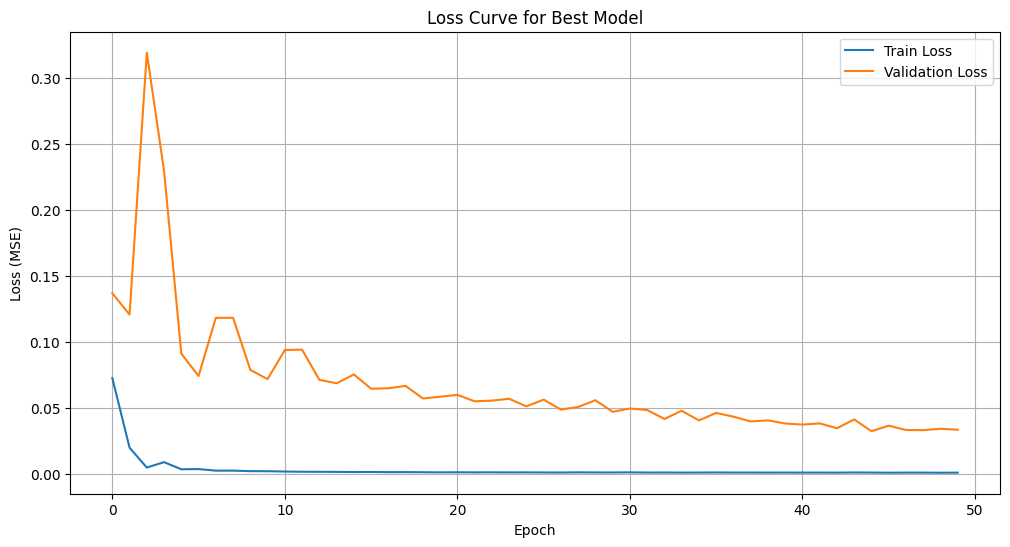

675.7525777816772
CPU times: user 10min 55s, sys: 36.7 s, total: 11min 31s
Wall time: 11min 15s


In [ ]:
%%time
start_time = time.time()
original,pred,train_pred=LSTM_train(df_10,build_model_10,10)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

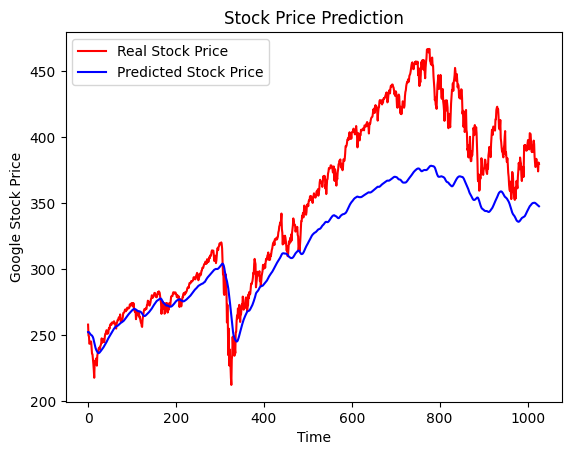

MSE: 1548.12
RMSE: 39.35
R^2: 0.66


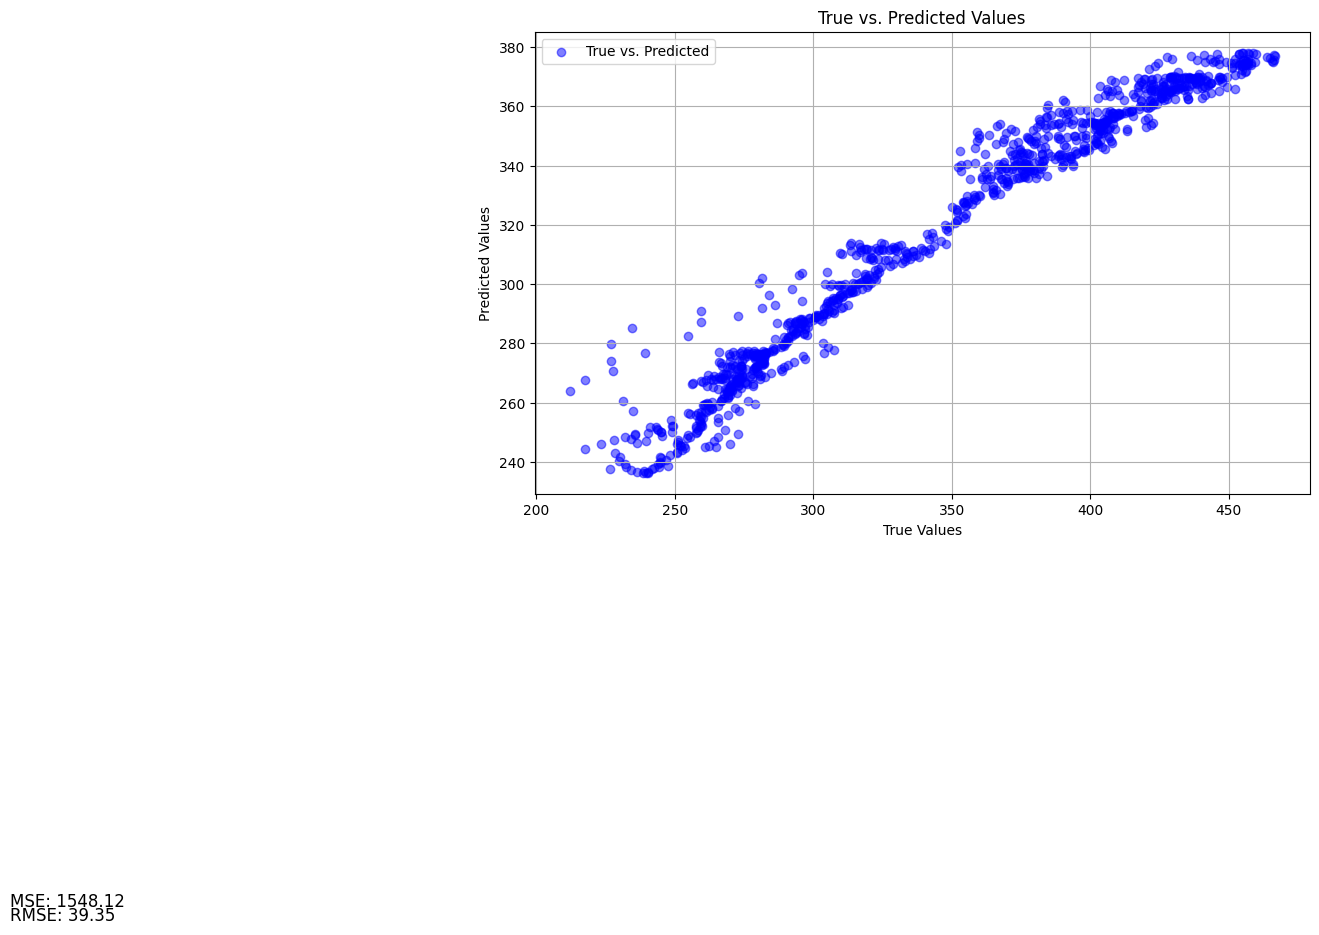

R^2: 0.66
0.616682767868042
CPU times: user 546 ms, sys: 125 ms, total: 672 ms
Wall time: 617 ms


In [ ]:
%%time
start_time = time.time()
LSTM_show(original,pred)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

lightgbm

In [ ]:
%%time
study=best_param(df_10)
lgb_predictions,model,lgb_original=Light_train(df_10,study)

[I 2023-09-08 03:15:26,766] A new study created in memory with name: no-name-68f85ae8-2b27-4357-8316-bff2ace6efbb
[I 2023-09-08 03:15:35,684] Trial 0 finished with value: 11609.413521451459 and parameters: {'reg_alpha': 5.142512673110245, 'reg_lambda': 2.1272653091611735, 'num_leaves': 92, 'min_child_samples': 100, 'max_depth': 50, 'learning_rate': 0.1, 'colsample_bytree': 0.2954296026319211, 'n_estimators': 4554, 'cat_smooth': 100, 'cat_l2': 17, 'min_data_per_group': 74}. Best is trial 0 with value: 11609.413521451459.


CPU times: user 20.6 s, sys: 146 ms, total: 20.7 s
Wall time: 11.9 s


11457.225704815253


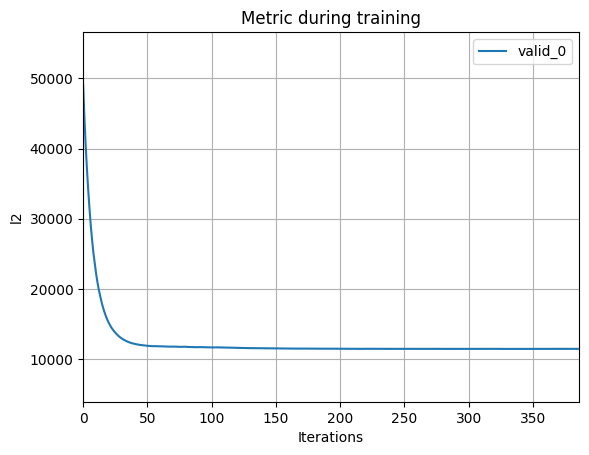

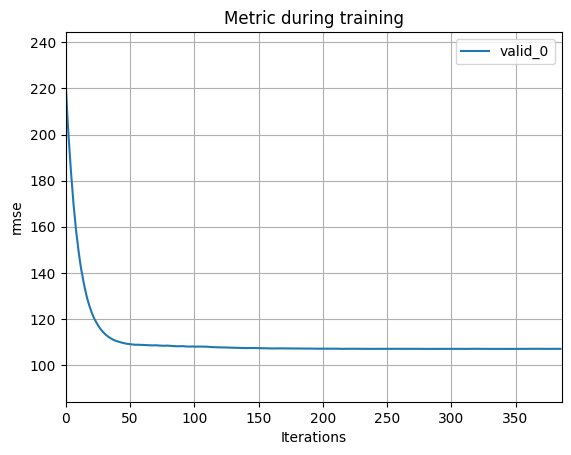

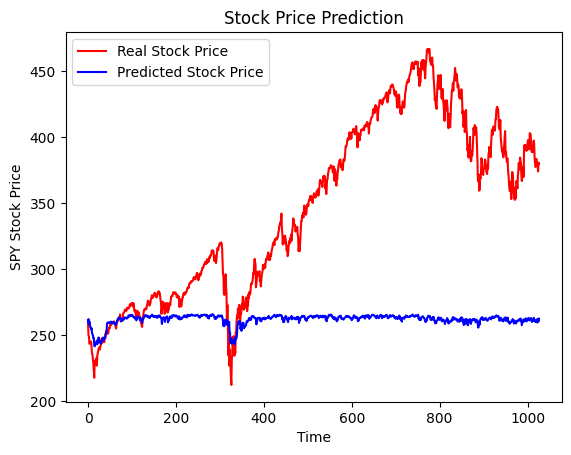

MSE: 11457.23
RMSE: 107.04
R^2: -1.55


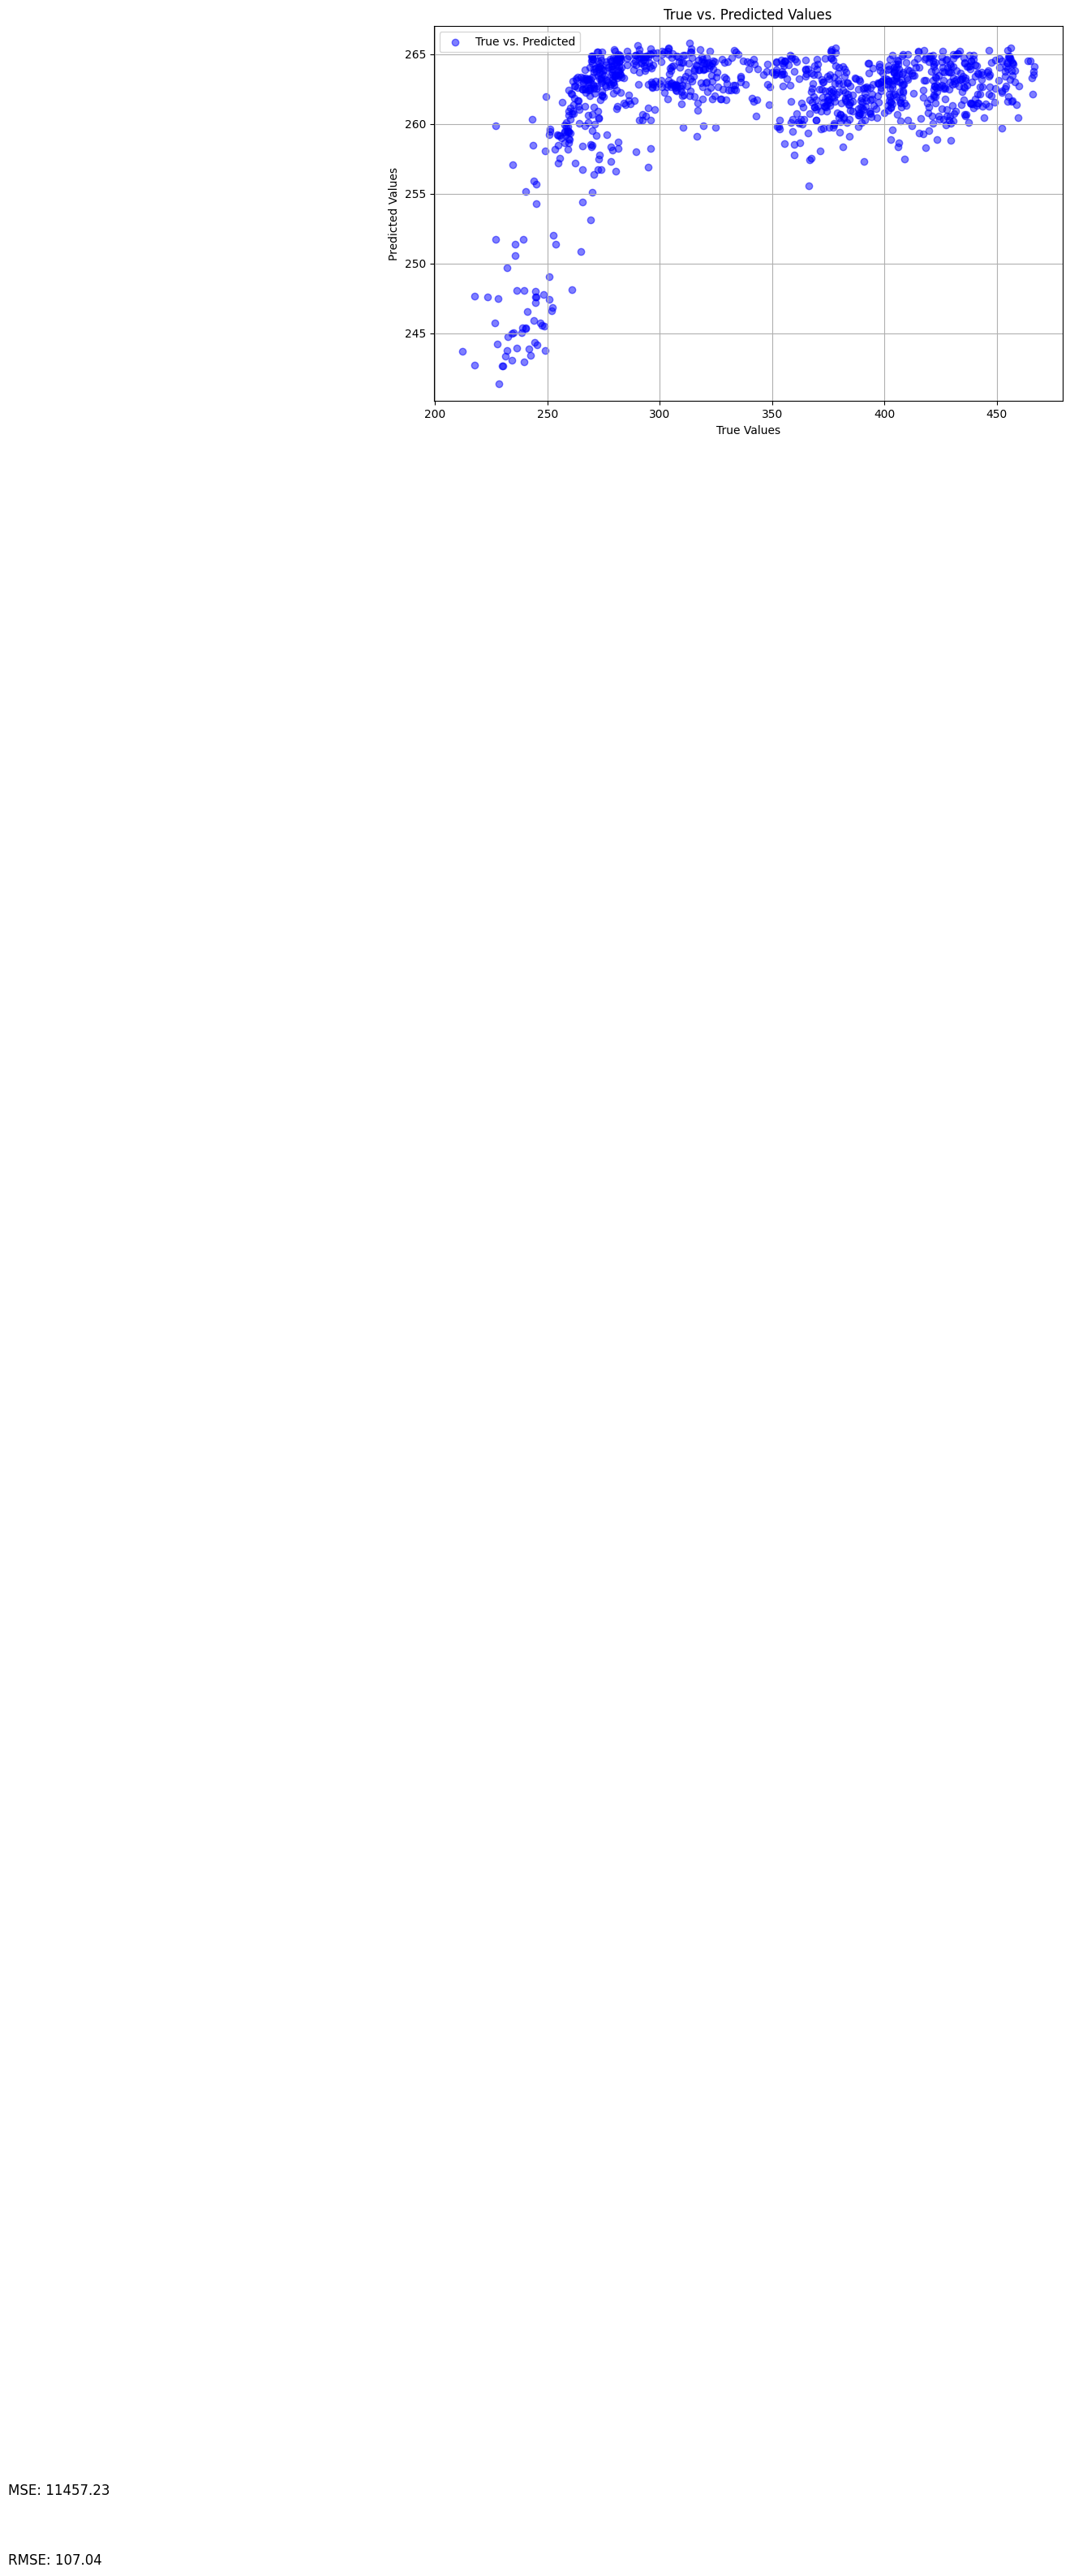

R^2: -1.55
CPU times: user 1.1 s, sys: 176 ms, total: 1.27 s
Wall time: 1.28 s


In [ ]:
%%time

LightGBM_show(lgb_predictions,model,lgb_original)

weight

In [ ]:
%%time
weight_prediction=weight(pred,original,lgb_predictions)

CPU times: user 4.3 ms, sys: 10 µs, total: 4.31 ms
Wall time: 4.01 ms


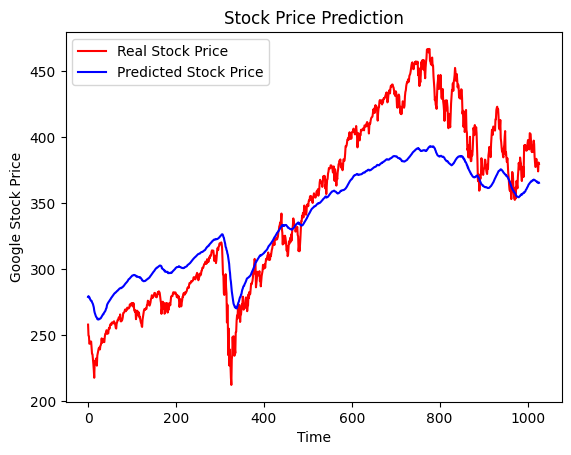

MSE: 978.57
RMSE: 31.28
R^2: 0.78


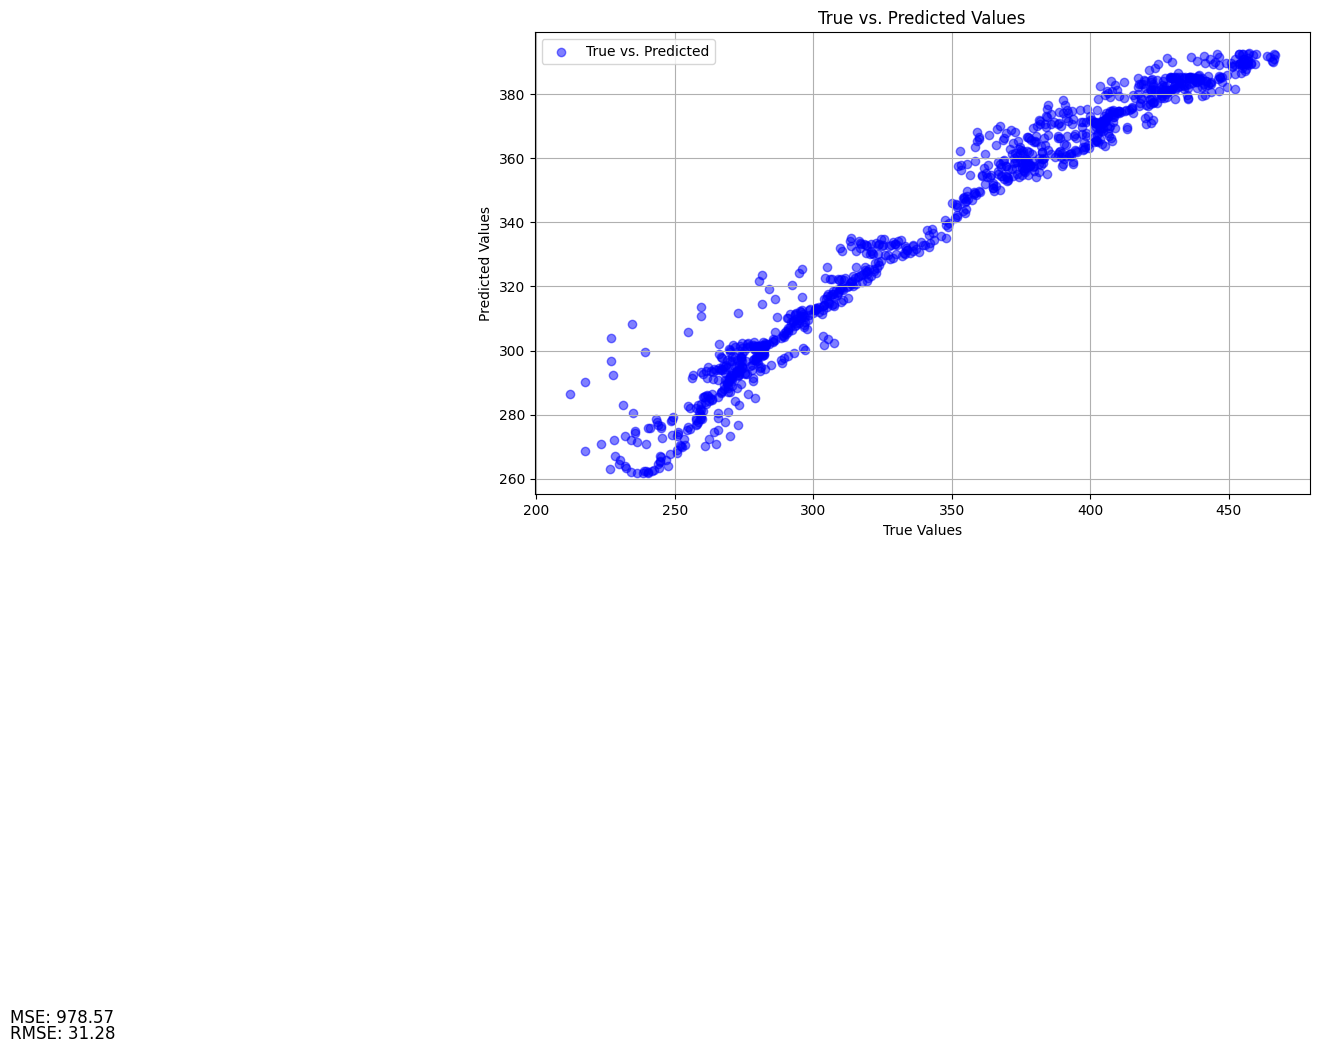

R^2: 0.78
CPU times: user 500 ms, sys: 182 ms, total: 682 ms
Wall time: 470 ms


In [ ]:
%%time
LSTM_show(original,weight_prediction)

new_variable

In [ ]:
%%time
lgb_predictions,model,lgb_original=new_variable(df_10,pred,train_pred)

[I 2023-09-08 03:16:12,075] A new study created in memory with name: no-name-67cdc020-c910-46eb-99f2-bbd39398cdfc
[I 2023-09-08 03:16:19,952] Trial 0 finished with value: 11156.699033699415 and parameters: {'reg_alpha': 4.628784622292425, 'reg_lambda': 8.527800931804032, 'num_leaves': 23, 'min_child_samples': 35, 'max_depth': 62, 'learning_rate': 0.1, 'colsample_bytree': 0.420153637111501, 'n_estimators': 4823, 'cat_smooth': 97, 'cat_l2': 7, 'min_data_per_group': 136}. Best is trial 0 with value: 11156.699033699415.


CPU times: user 21 s, sys: 85.5 ms, total: 21.1 s
Wall time: 12.1 s


11134.555495490185


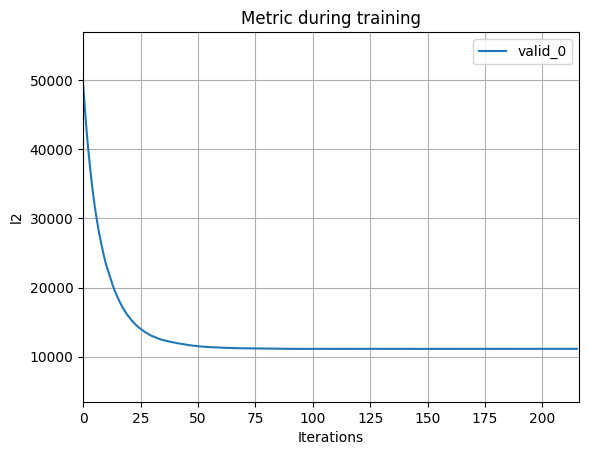

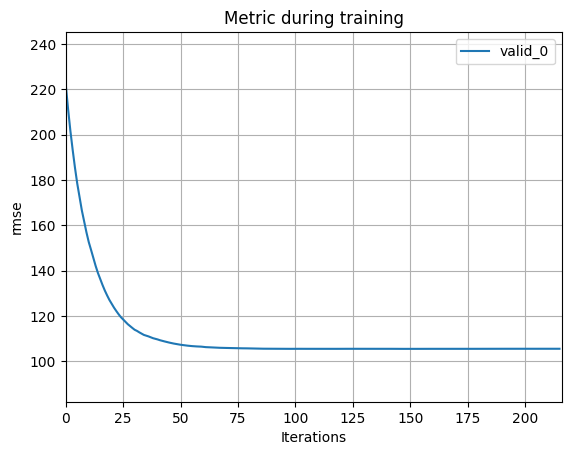

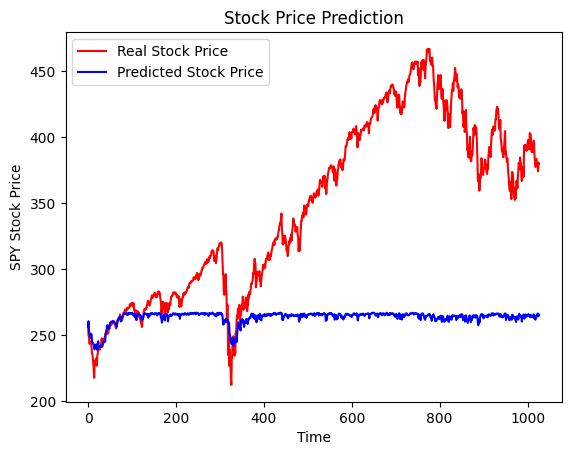

MSE: 11134.56
RMSE: 105.52
R^2: -1.48


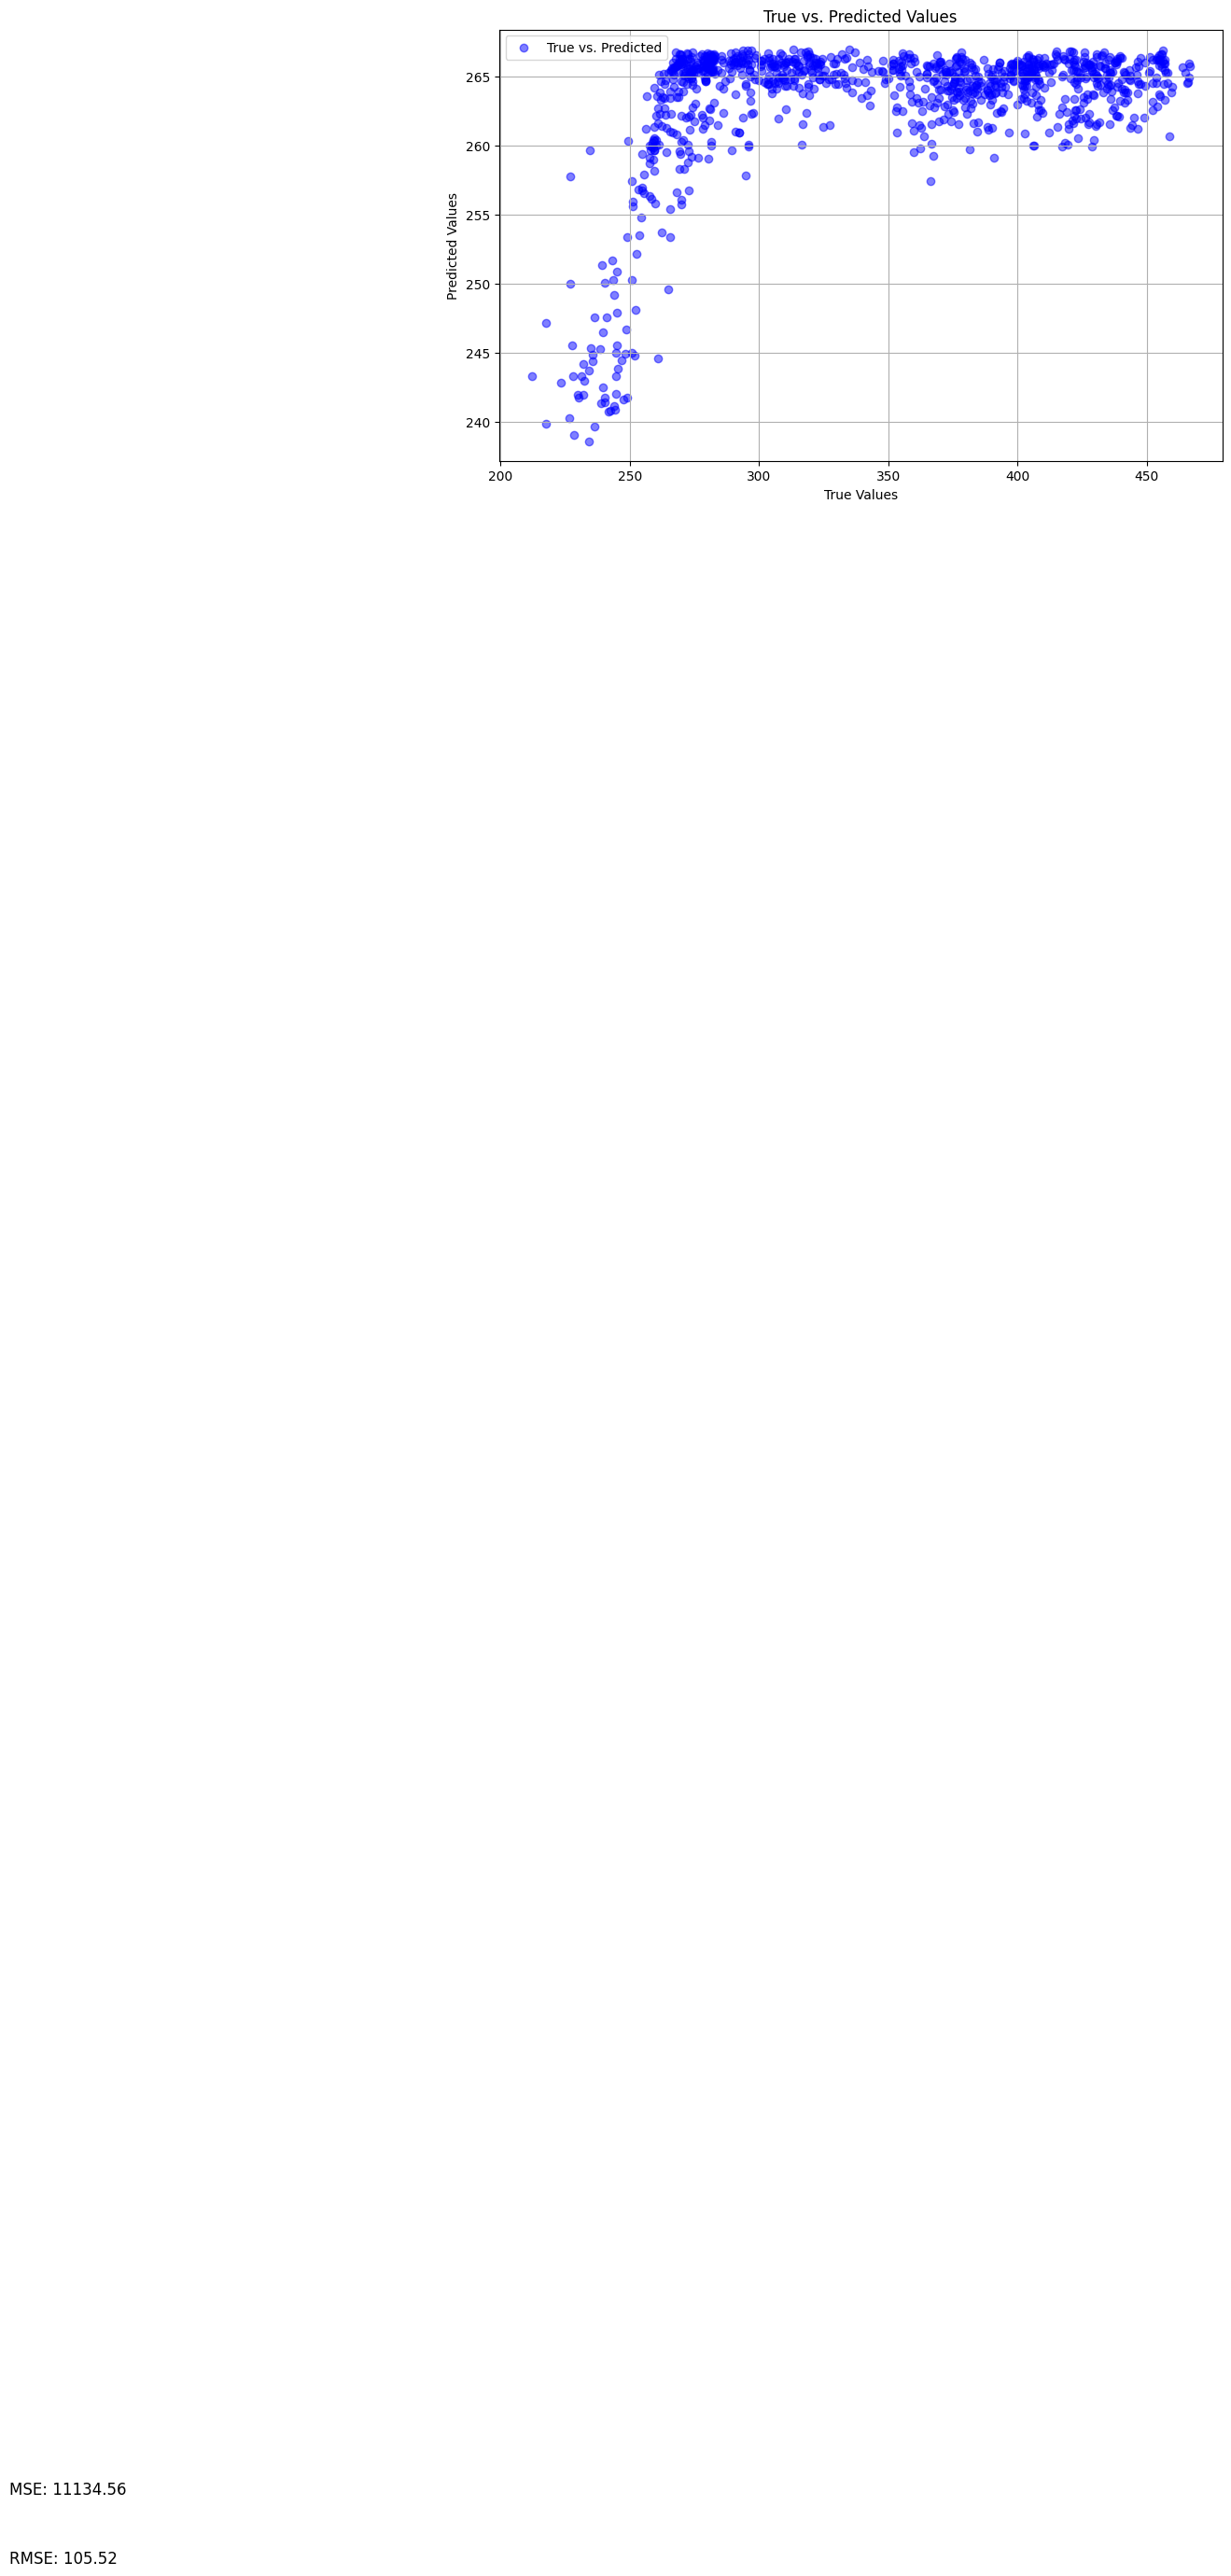

R^2: -1.48
CPU times: user 1.67 s, sys: 420 ms, total: 2.09 s
Wall time: 1.66 s


In [ ]:
%%time
LightGBM_show(lgb_predictions,model,lgb_original)

**df_20**

lstm prediction

<ipython-input-70-d9085b19990a>:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=model,verbose=1,validation_data=(testX,testY))


Epoch 1/10
7/7 [==============================] - 4s 233ms/step - loss: 0.1004 - val_loss: 0.1129
Epoch 2/10
7/7 [==============================] - 1s 135ms/step - loss: 0.0191 - val_loss: 0.3495
Epoch 3/10
7/7 [==============================] - 1s 135ms/step - loss: 0.0134 - val_loss: 0.2859
Epoch 4/10
7/7 [==============================] - 1s 134ms/step - loss: 0.0061 - val_loss: 0.1699
Epoch 5/10
7/7 [==============================] - 1s 146ms/step - loss: 0.0054 - val_loss: 0.2064
Epoch 6/10
7/7 [==============================] - 2s 222ms/step - loss: 0.0047 - val_loss: 0.1961
Epoch 6: early stopping
2/2 [==============================] - 0s 76ms/step - loss: 0.0084
Epoch 1/10
7/7 [==============================] - 4s 232ms/step - loss: 0.1500 - val_loss: 0.1449
Epoch 2/10
7/7 [==============================] - 1s 132ms/step - loss: 0.0371 - val_loss: 0.4571
Epoch 3/10
7/7 [==============================] - 1s 128ms/step - loss: 0.0218 - val_loss: 0.4127
Epoch 4/10
7/7 [===========

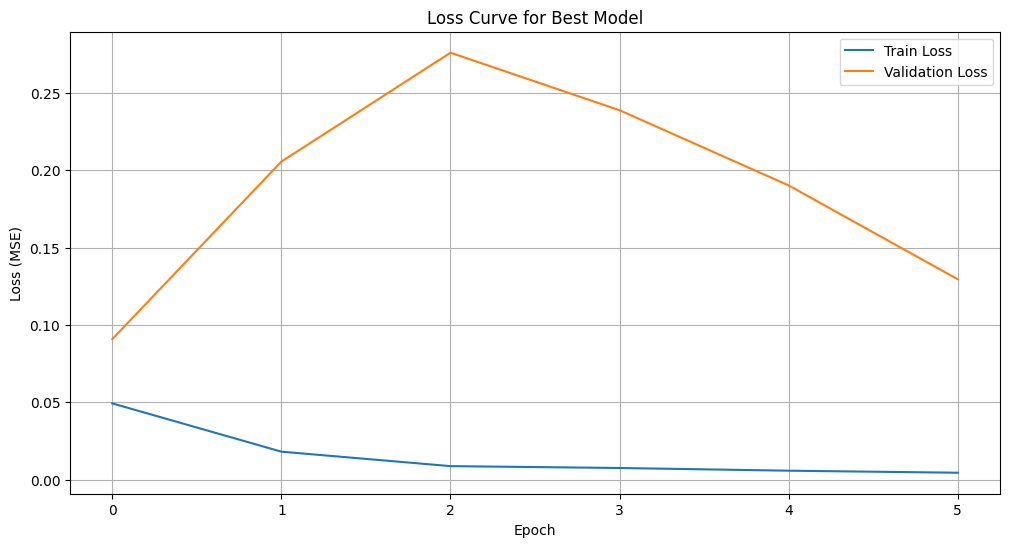

551.6408002376556
CPU times: user 9min 3s, sys: 19.7 s, total: 9min 23s
Wall time: 9min 11s


In [ ]:
%%time
start_time = time.time()
original,pred,train_pred=LSTM_train(df_20,build_model_20,20)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

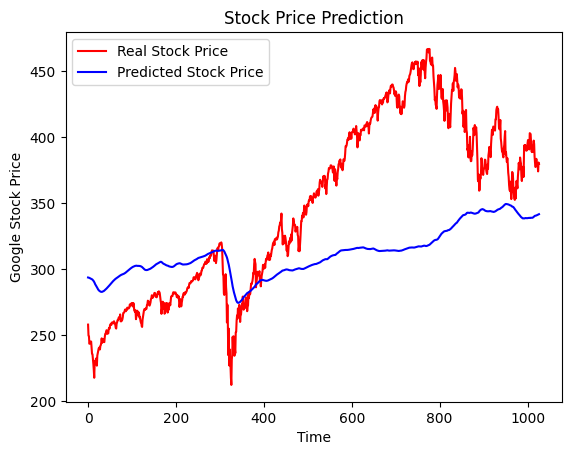

MSE: 4323.54
RMSE: 65.75
R^2: 0.04


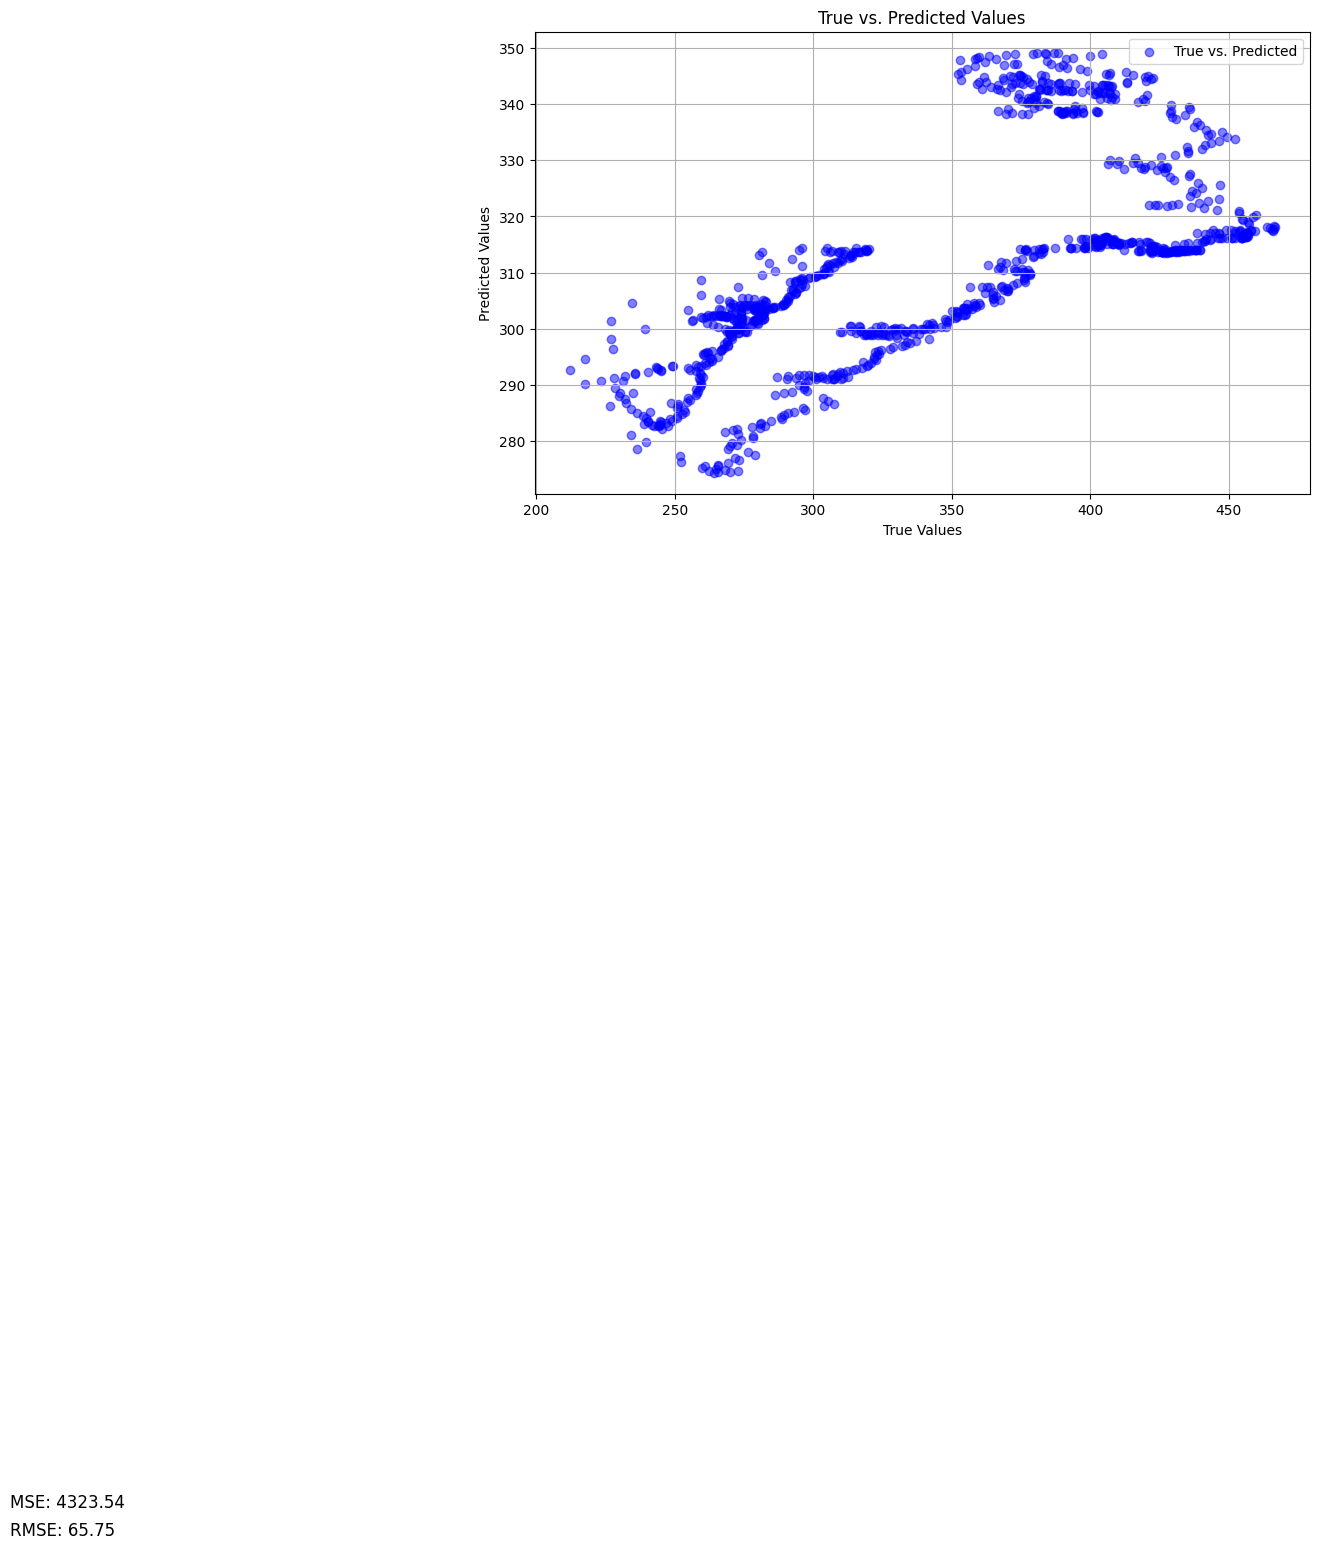

R^2: 0.04
1.425581932067871
CPU times: user 1.44 s, sys: 193 ms, total: 1.64 s
Wall time: 1.43 s


In [ ]:
%%time
start_time = time.time()
LSTM_show(original,pred)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

lightgbm

In [ ]:
%%time
study=best_param(df_20)
lgb_predictions,model,lgb_original=Light_train(df_20,study)

[I 2023-09-08 03:25:50,194] A new study created in memory with name: no-name-ba27a7c3-6e75-448f-8524-6d204686c992
[I 2023-09-08 03:26:16,389] Trial 0 finished with value: 17956.643657107958 and parameters: {'reg_alpha': 4.976842670176828, 'reg_lambda': 2.21269024953584, 'num_leaves': 193, 'min_child_samples': 46, 'max_depth': 16, 'learning_rate': 0.01, 'colsample_bytree': 0.11055694853680481, 'n_estimators': 6385, 'cat_smooth': 16, 'cat_l2': 3, 'min_data_per_group': 196}. Best is trial 0 with value: 17956.643657107958.


CPU times: user 58.8 s, sys: 810 ms, total: 59.6 s
Wall time: 34.1 s


17912.53304260982


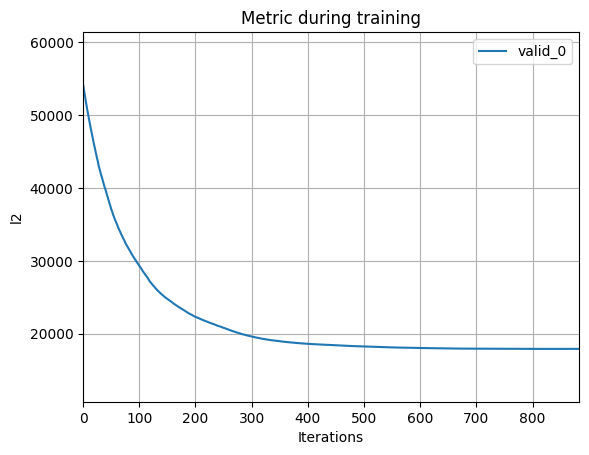

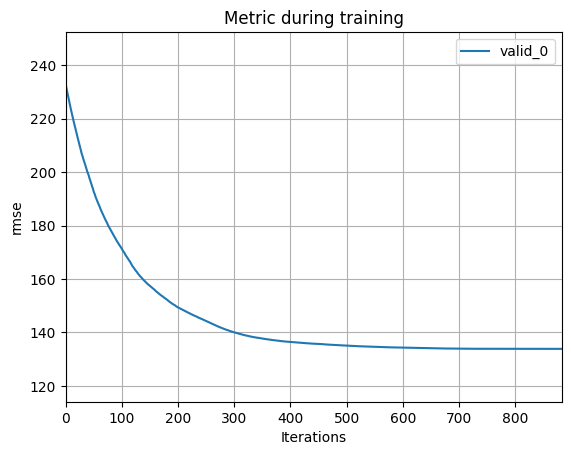

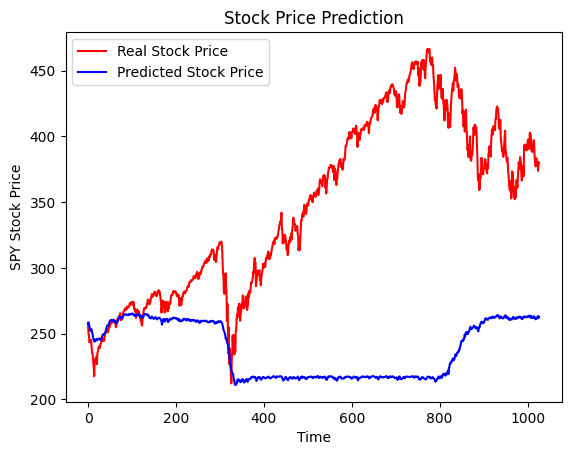

MSE: 17912.53
RMSE: 133.84
R^2: -2.99


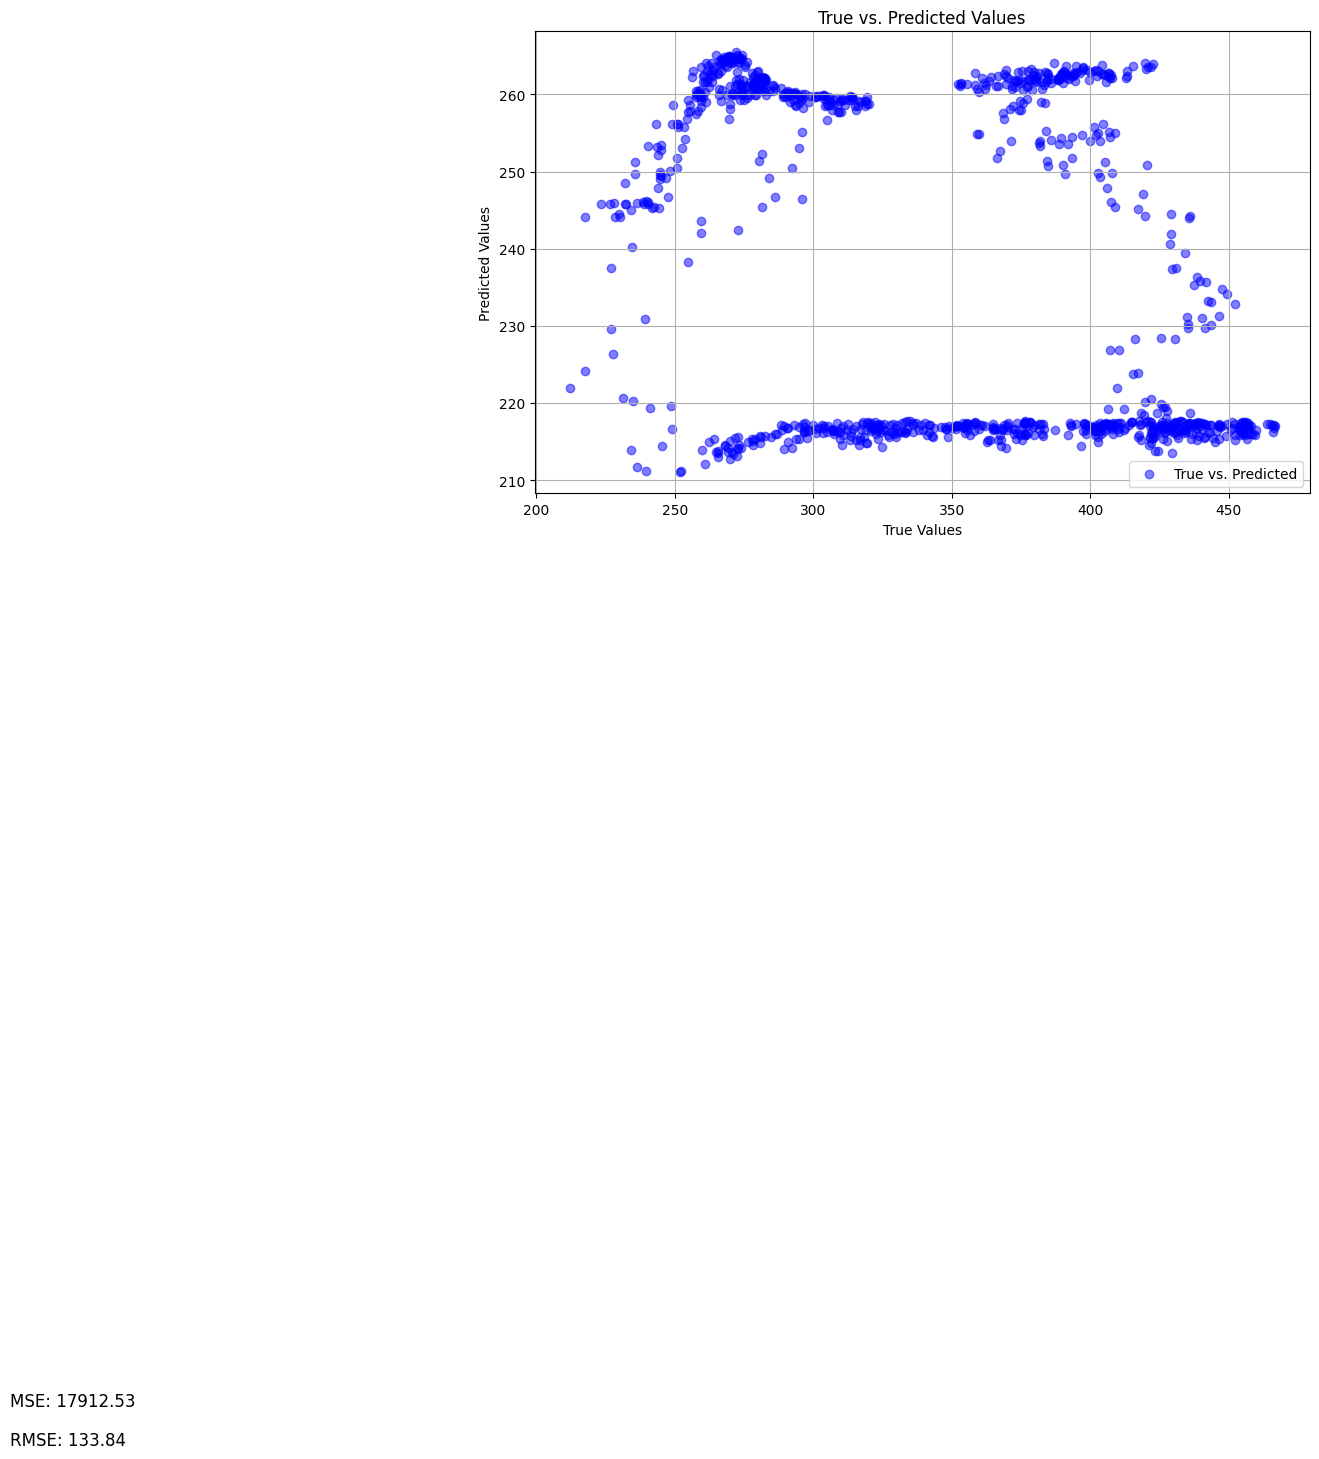

R^2: -2.99
CPU times: user 877 ms, sys: 419 ms, total: 1.3 s
Wall time: 847 ms


In [ ]:
%%time
LightGBM_show(lgb_predictions,model,lgb_original)

weight

In [ ]:
%%time
weight_prediction=weight(pred,original,lgb_predictions)

CPU times: user 3.9 ms, sys: 0 ns, total: 3.9 ms
Wall time: 3.73 ms


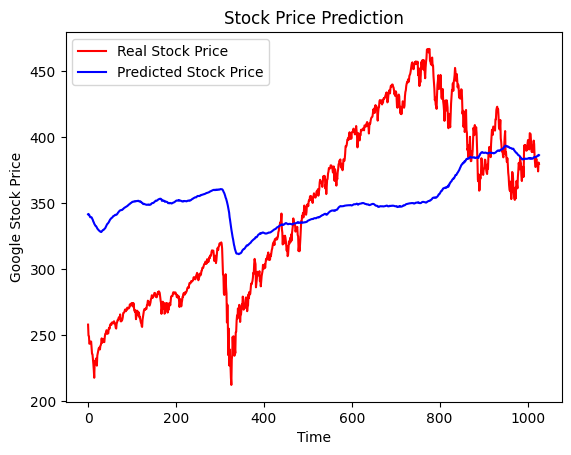

MSE: 3714.91
RMSE: 60.95
R^2: 0.17


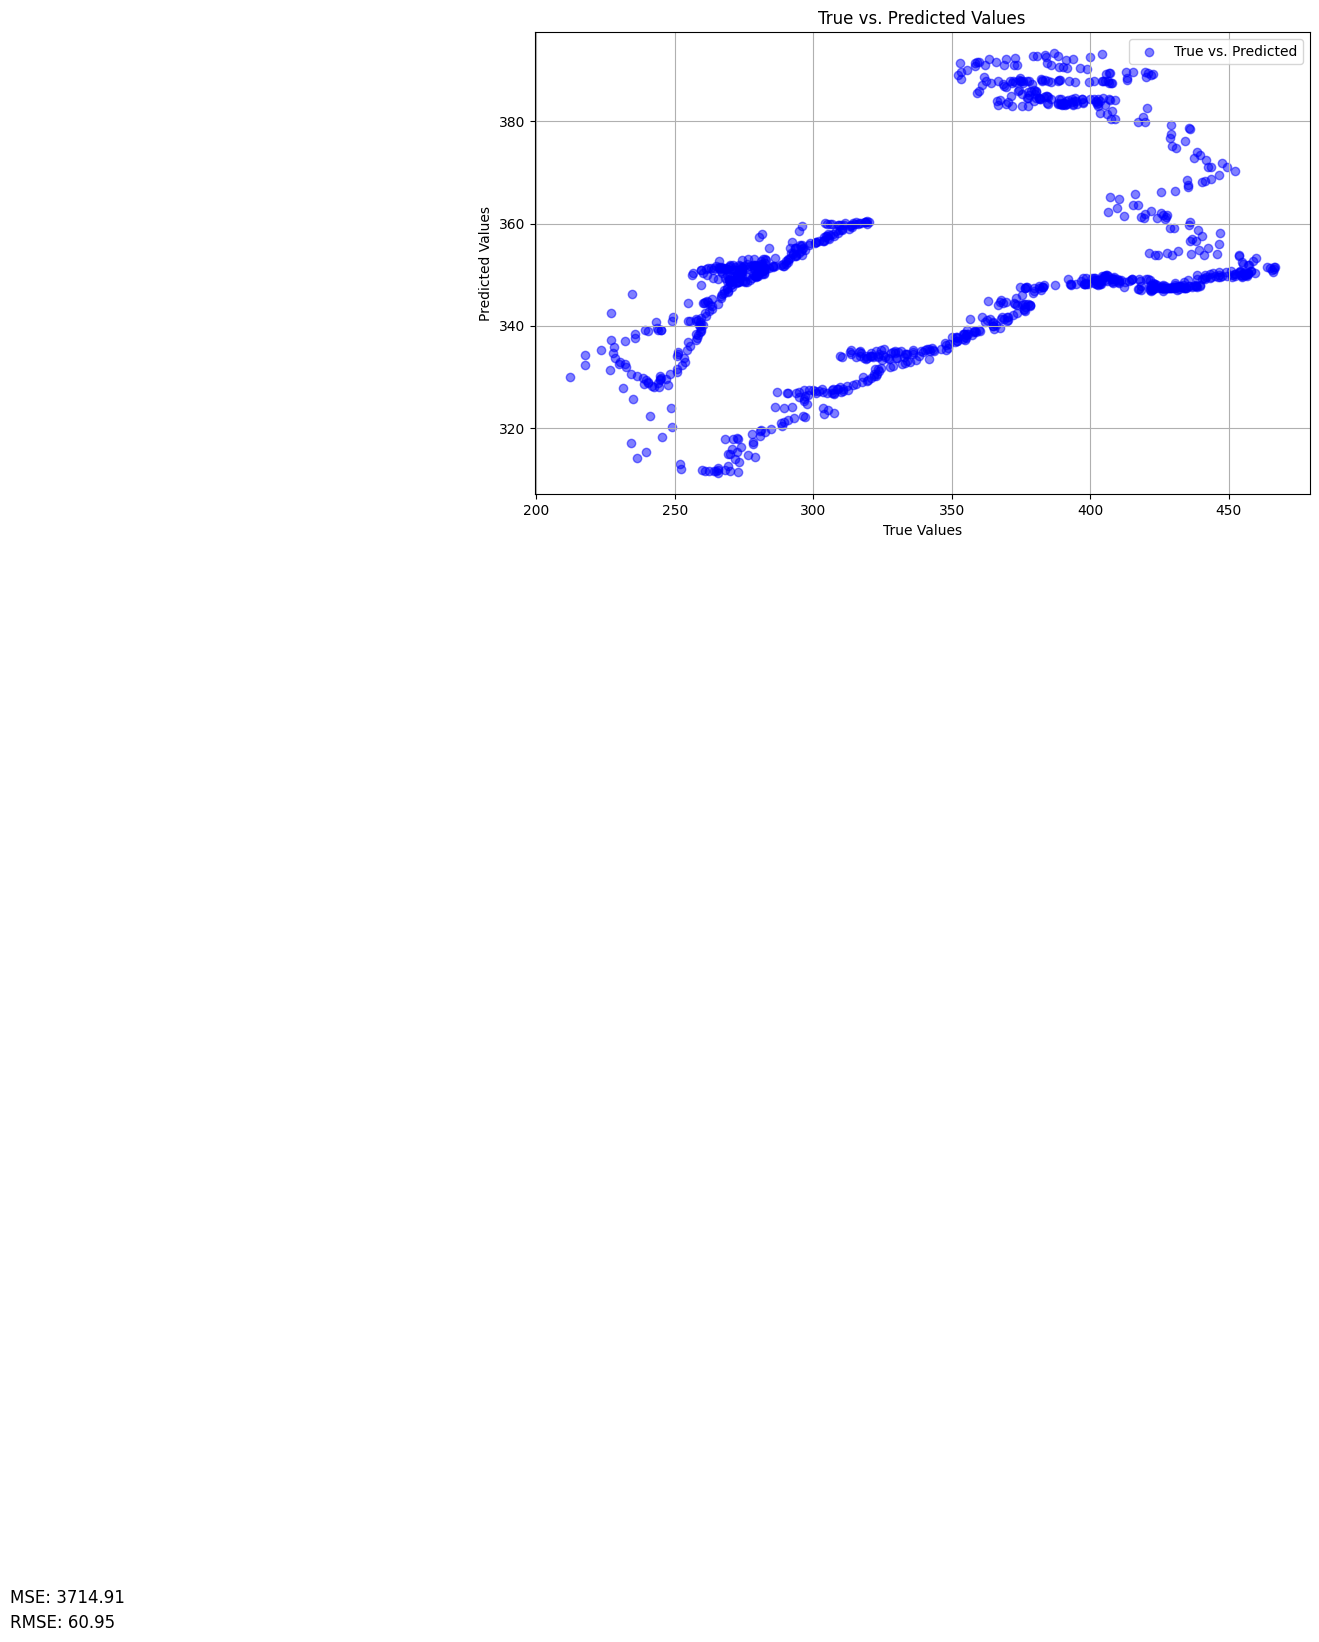

R^2: 0.17
CPU times: user 481 ms, sys: 169 ms, total: 650 ms
Wall time: 472 ms


In [ ]:
%%time
LSTM_show(original,weight_prediction)

new_variable

In [ ]:
%%time
lgb_predictions,model,lgb_original=new_variable(df_20,pred,train_pred)

[I 2023-09-08 03:26:25,670] A new study created in memory with name: no-name-42f4af83-b7c0-4274-a05f-6b085708251a
[I 2023-09-08 03:27:58,527] Trial 0 finished with value: 18141.23727252893 and parameters: {'reg_alpha': 6.437929324264208, 'reg_lambda': 1.5291009854819952, 'num_leaves': 231, 'min_child_samples': 73, 'max_depth': 45, 'learning_rate': 0.005, 'colsample_bytree': 0.39913306552048367, 'n_estimators': 4047, 'cat_smooth': 56, 'cat_l2': 5, 'min_data_per_group': 156}. Best is trial 0 with value: 18141.23727252893.


CPU times: user 3min 29s, sys: 1.07 s, total: 3min 30s
Wall time: 1min 57s


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
18032.077945721045


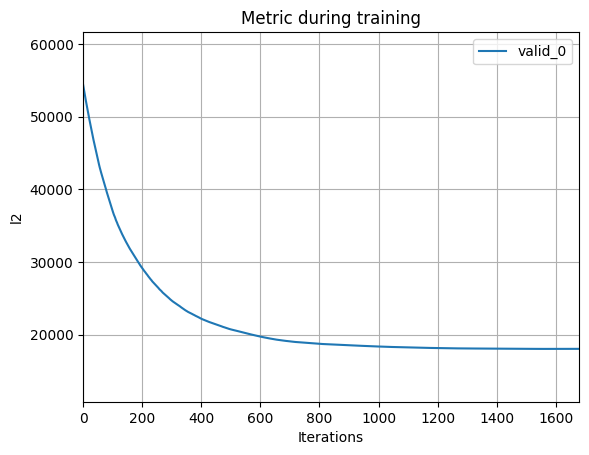

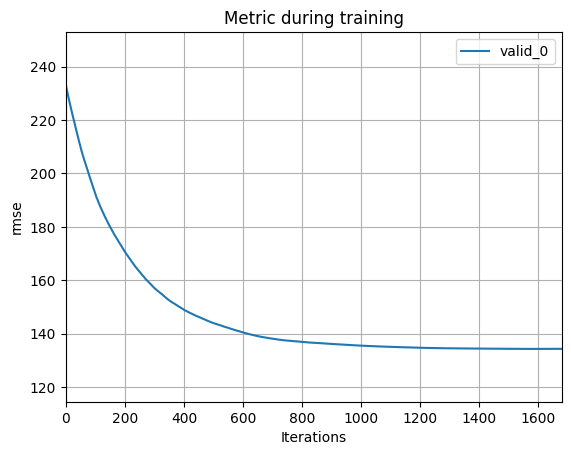

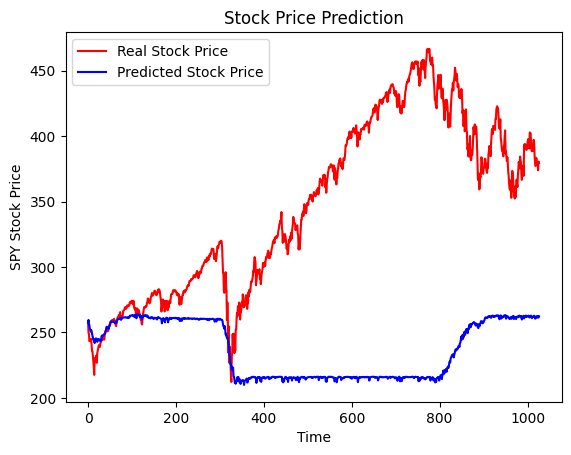

MSE: 18032.08
RMSE: 134.28
R^2: -3.01


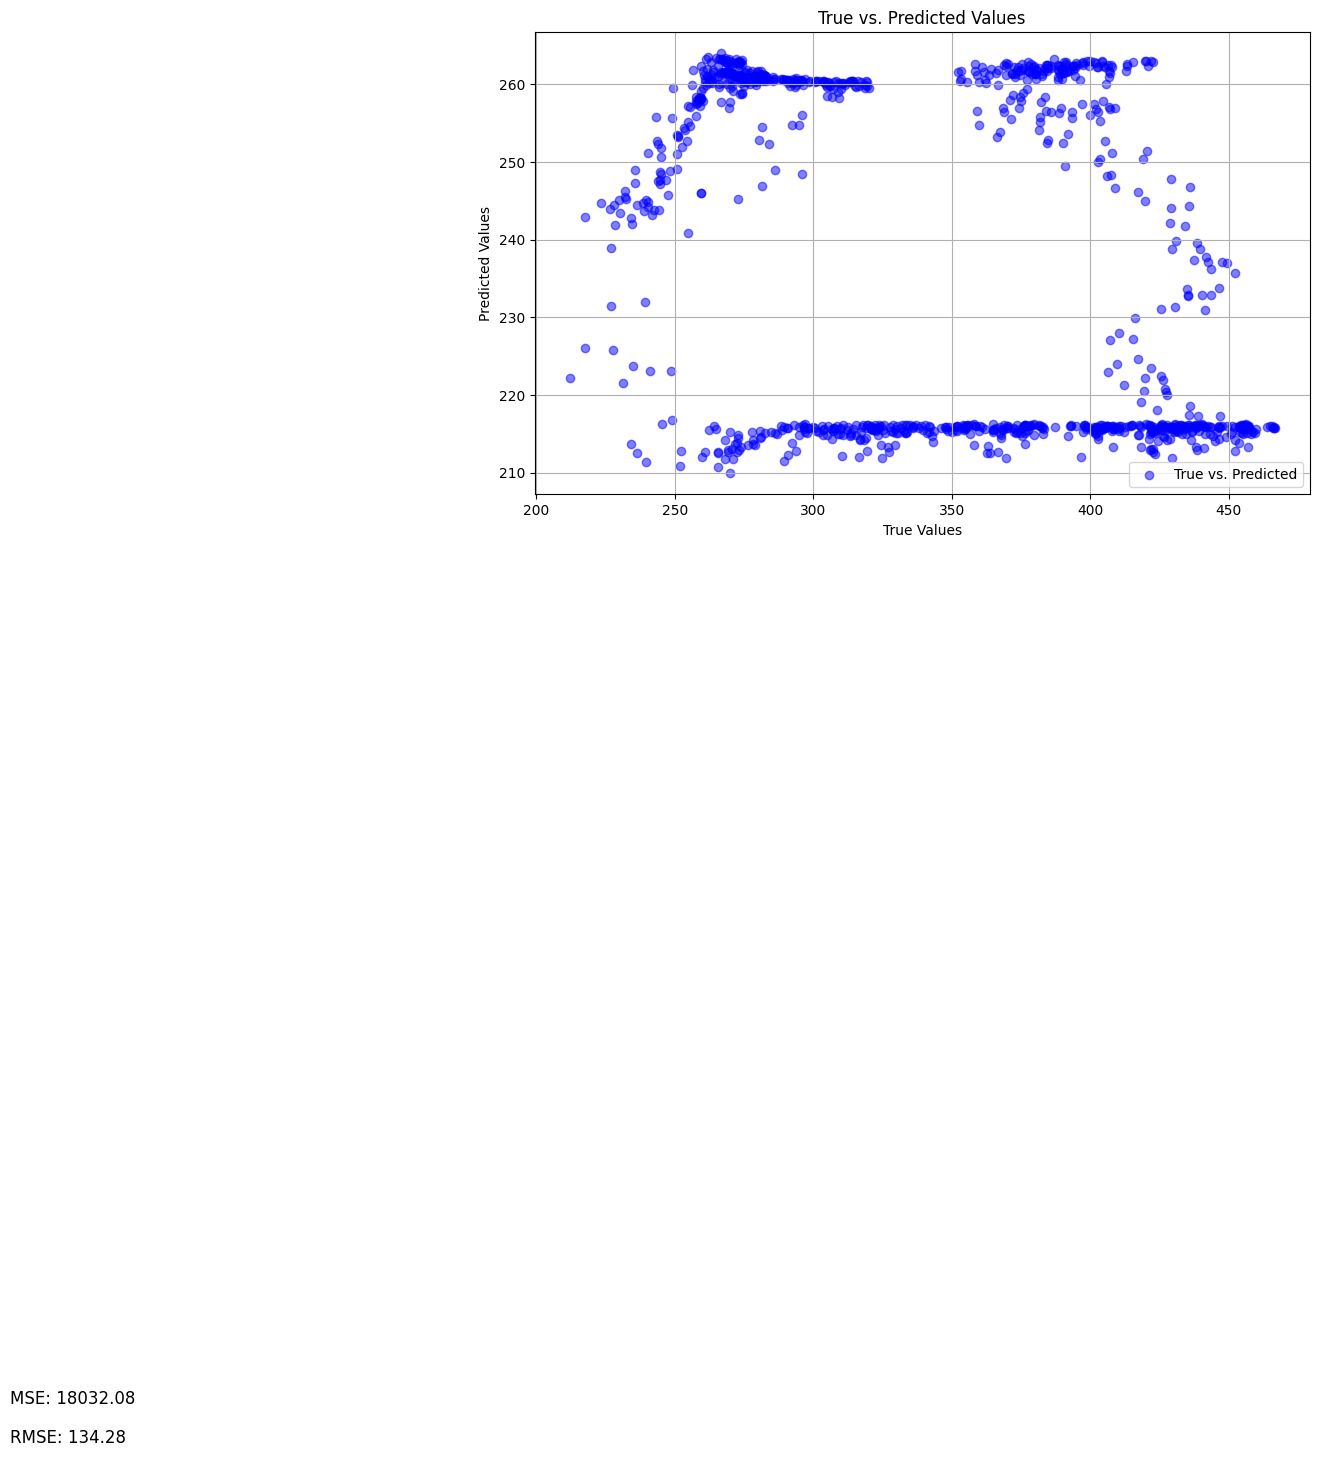

R^2: -3.01


In [ ]:
%time
LightGBM_show(lgb_predictions,model,lgb_original)

**df_30**

lstm prediction

<ipython-input-70-d9085b19990a>:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=model,verbose=1,validation_data=(testX,testY))


Epoch 1/10
7/7 [==============================] - 4s 262ms/step - loss: 0.0723 - val_loss: 0.2325
Epoch 2/10
7/7 [==============================] - 1s 174ms/step - loss: 0.0205 - val_loss: 0.1755
Epoch 3/10
7/7 [==============================] - 2s 235ms/step - loss: 0.0103 - val_loss: 0.1576
Epoch 4/10
7/7 [==============================] - 2s 318ms/step - loss: 0.0079 - val_loss: 0.2018
Epoch 5/10
7/7 [==============================] - 1s 177ms/step - loss: 0.0054 - val_loss: 0.0850
Epoch 6/10
7/7 [==============================] - 1s 130ms/step - loss: 0.0043 - val_loss: 0.0951
Epoch 7/10
7/7 [==============================] - 1s 130ms/step - loss: 0.0036 - val_loss: 0.0692
Epoch 8/10
7/7 [==============================] - 1s 133ms/step - loss: 0.0034 - val_loss: 0.0906
Epoch 9/10
7/7 [==============================] - 1s 139ms/step - loss: 0.0030 - val_loss: 0.0644
Epoch 10/10
2/2 [==============================] - 0s 40ms/step - loss: 4.0831e-04
Epoch 1/10
7/7 [===================

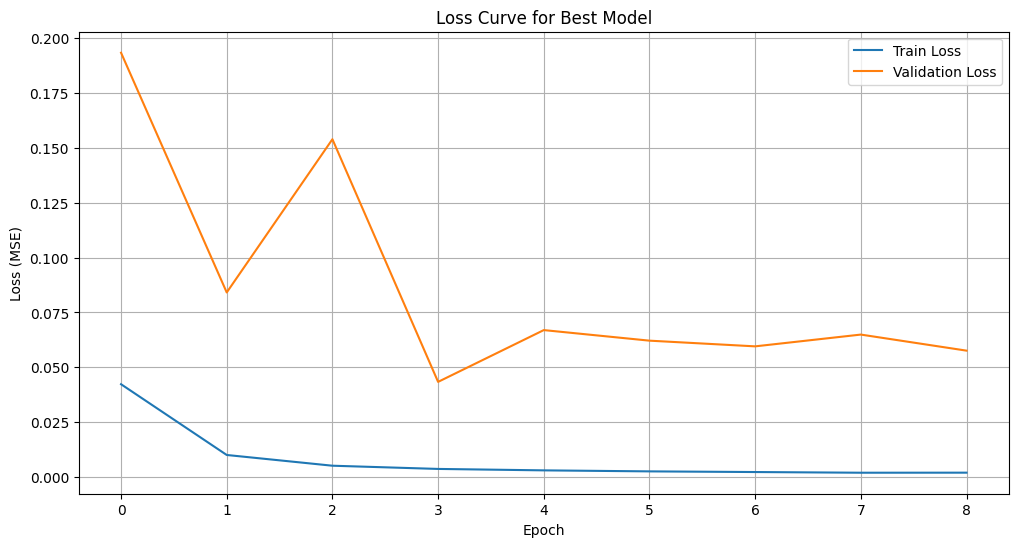

831.8280522823334
CPU times: user 15min 1s, sys: 34.9 s, total: 15min 36s
Wall time: 13min 51s


In [ ]:
%%time
start_time = time.time()
original,pred,train_pred=LSTM_train(df_30,build_model_30,30)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

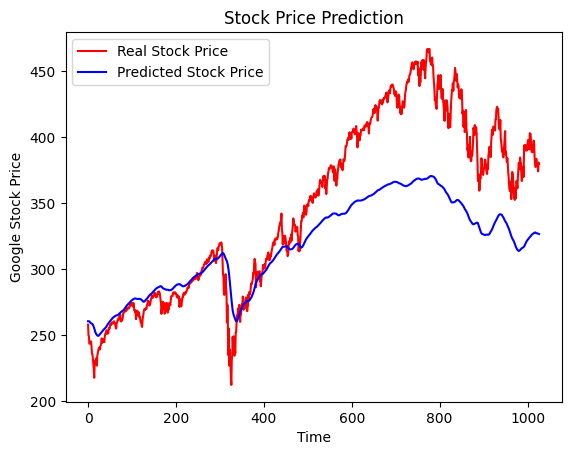

MSE: 2065.70
RMSE: 45.45
R^2: 0.54


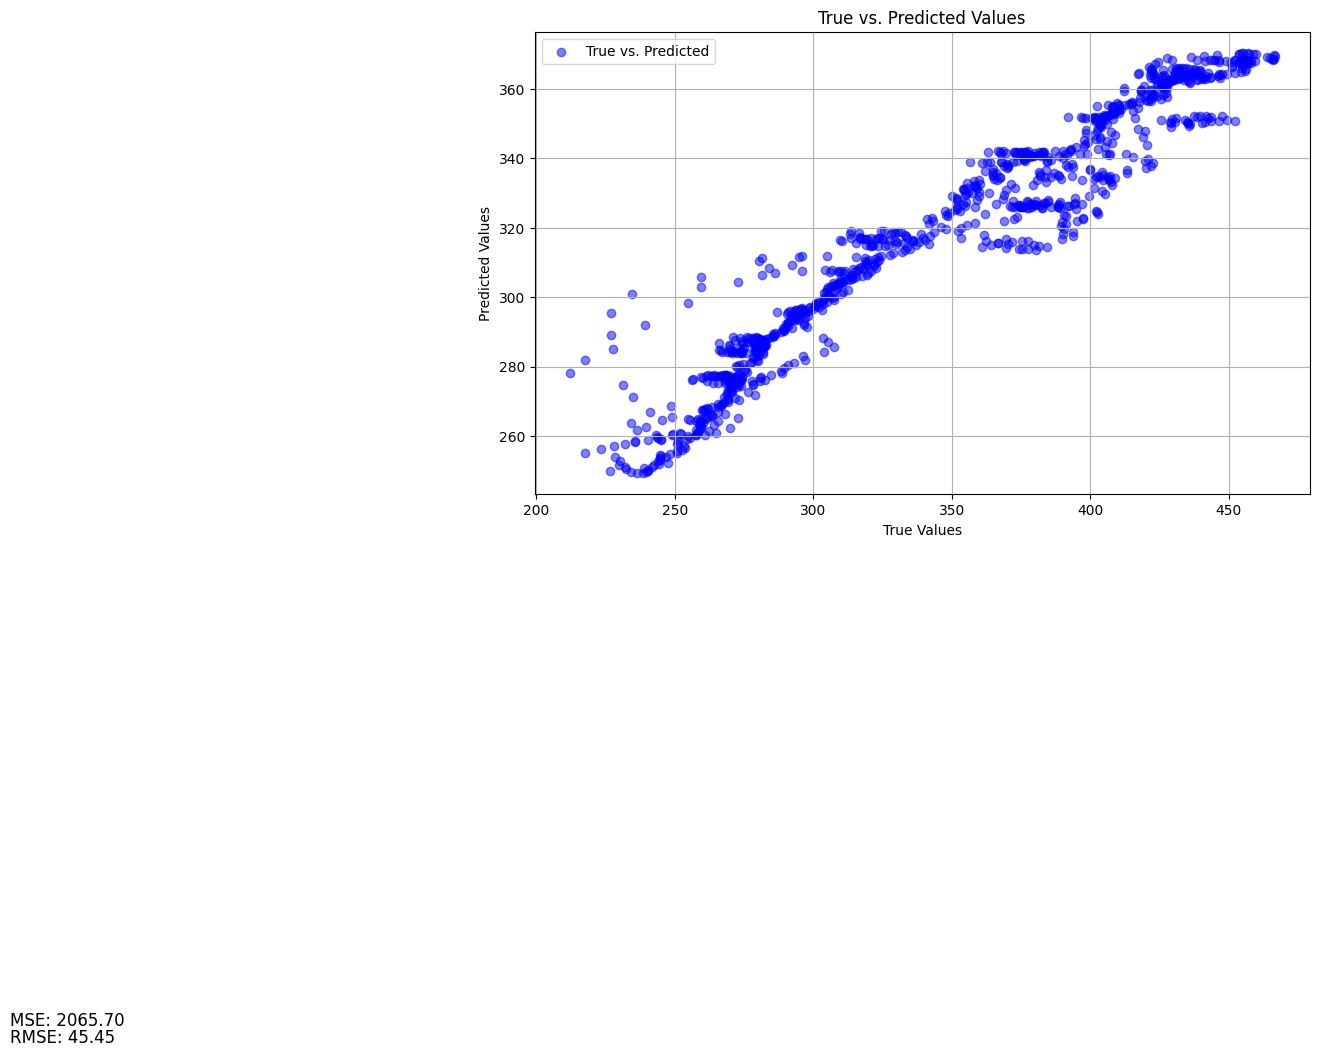

R^2: 0.54
0.45543694496154785
CPU times: user 474 ms, sys: 188 ms, total: 662 ms
Wall time: 456 ms


In [ ]:
%%time
start_time = time.time()
LSTM_show(original,pred)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

lightgbm

In [ ]:
%%time
study=best_param(df_30)
lgb_predictions,model,lgb_original=Light_train(df_30,study)

[I 2023-09-08 03:42:16,997] A new study created in memory with name: no-name-619ccecb-d1fa-4038-8f0b-ed3e83167b92
[I 2023-09-08 03:43:37,884] Trial 0 finished with value: 17663.81892067349 and parameters: {'reg_alpha': 6.844345815639004, 'reg_lambda': 4.474159634332949, 'num_leaves': 316, 'min_child_samples': 11, 'max_depth': 58, 'learning_rate': 0.01, 'colsample_bytree': 0.4530670431280781, 'n_estimators': 2633, 'cat_smooth': 58, 'cat_l2': 6, 'min_data_per_group': 66}. Best is trial 0 with value: 17663.81892067349.


CPU times: user 4min 31s, sys: 2.74 s, total: 4min 34s
Wall time: 2min 32s


17672.269314604822


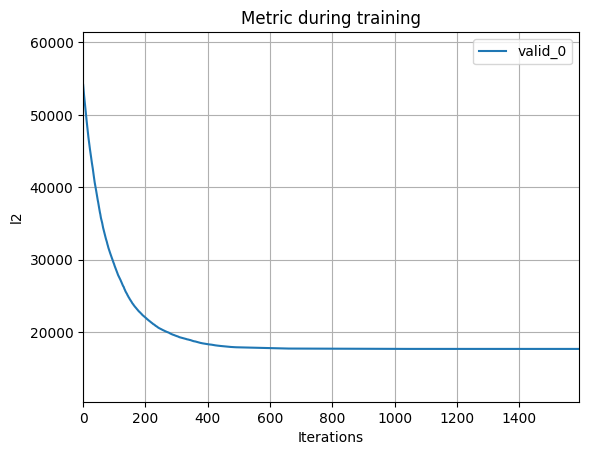

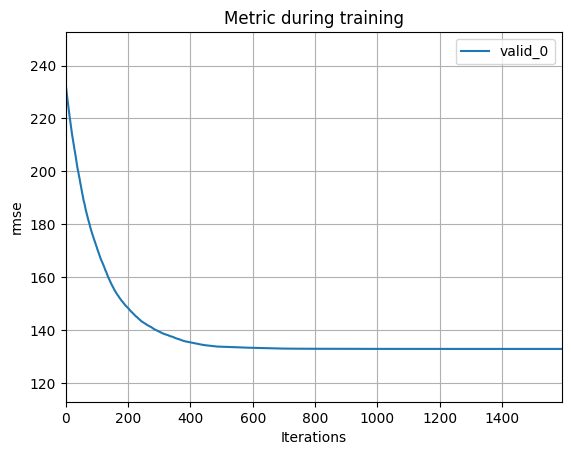

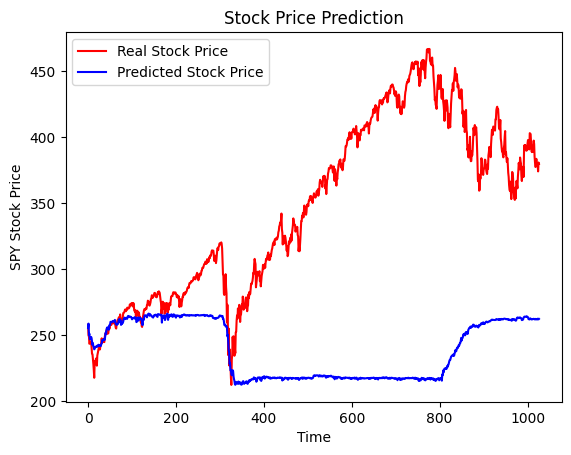

MSE: 17672.27
RMSE: 132.94
R^2: -2.93


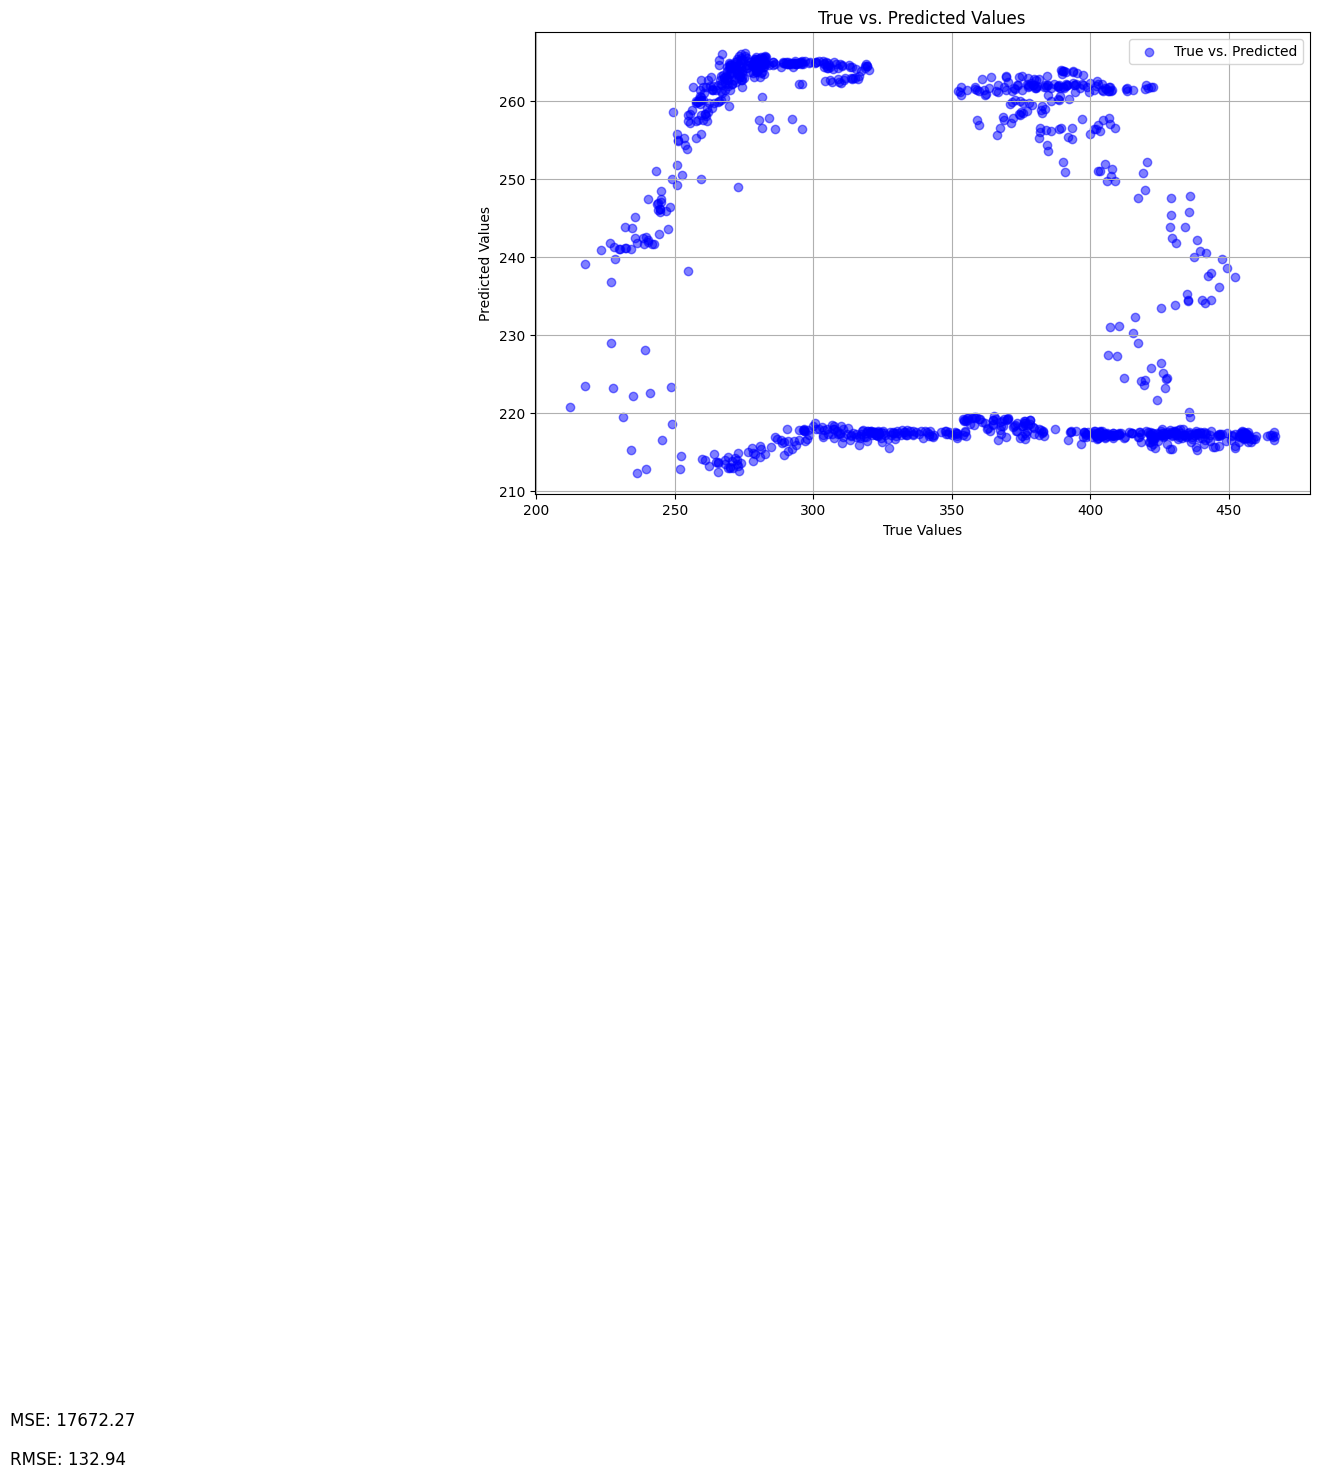

R^2: -2.93
CPU times: user 901 ms, sys: 378 ms, total: 1.28 s
Wall time: 872 ms


In [ ]:
%%time
LightGBM_show(lgb_predictions,model,lgb_original)

weight

In [ ]:
%%time
weight_prediction=weight(pred,original,lgb_predictions)

CPU times: user 2.34 ms, sys: 0 ns, total: 2.34 ms
Wall time: 2.36 ms


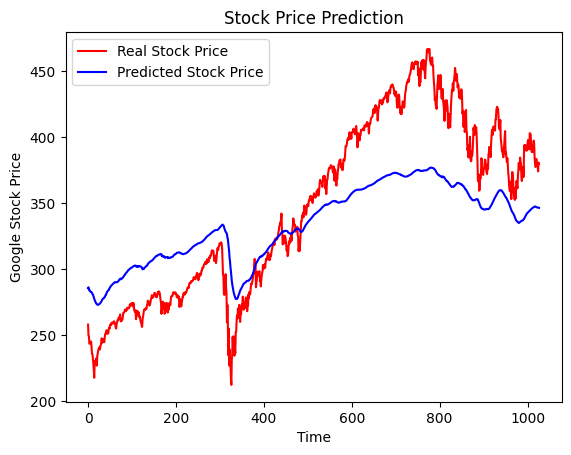

MSE: 1740.98
RMSE: 41.73
R^2: 0.61


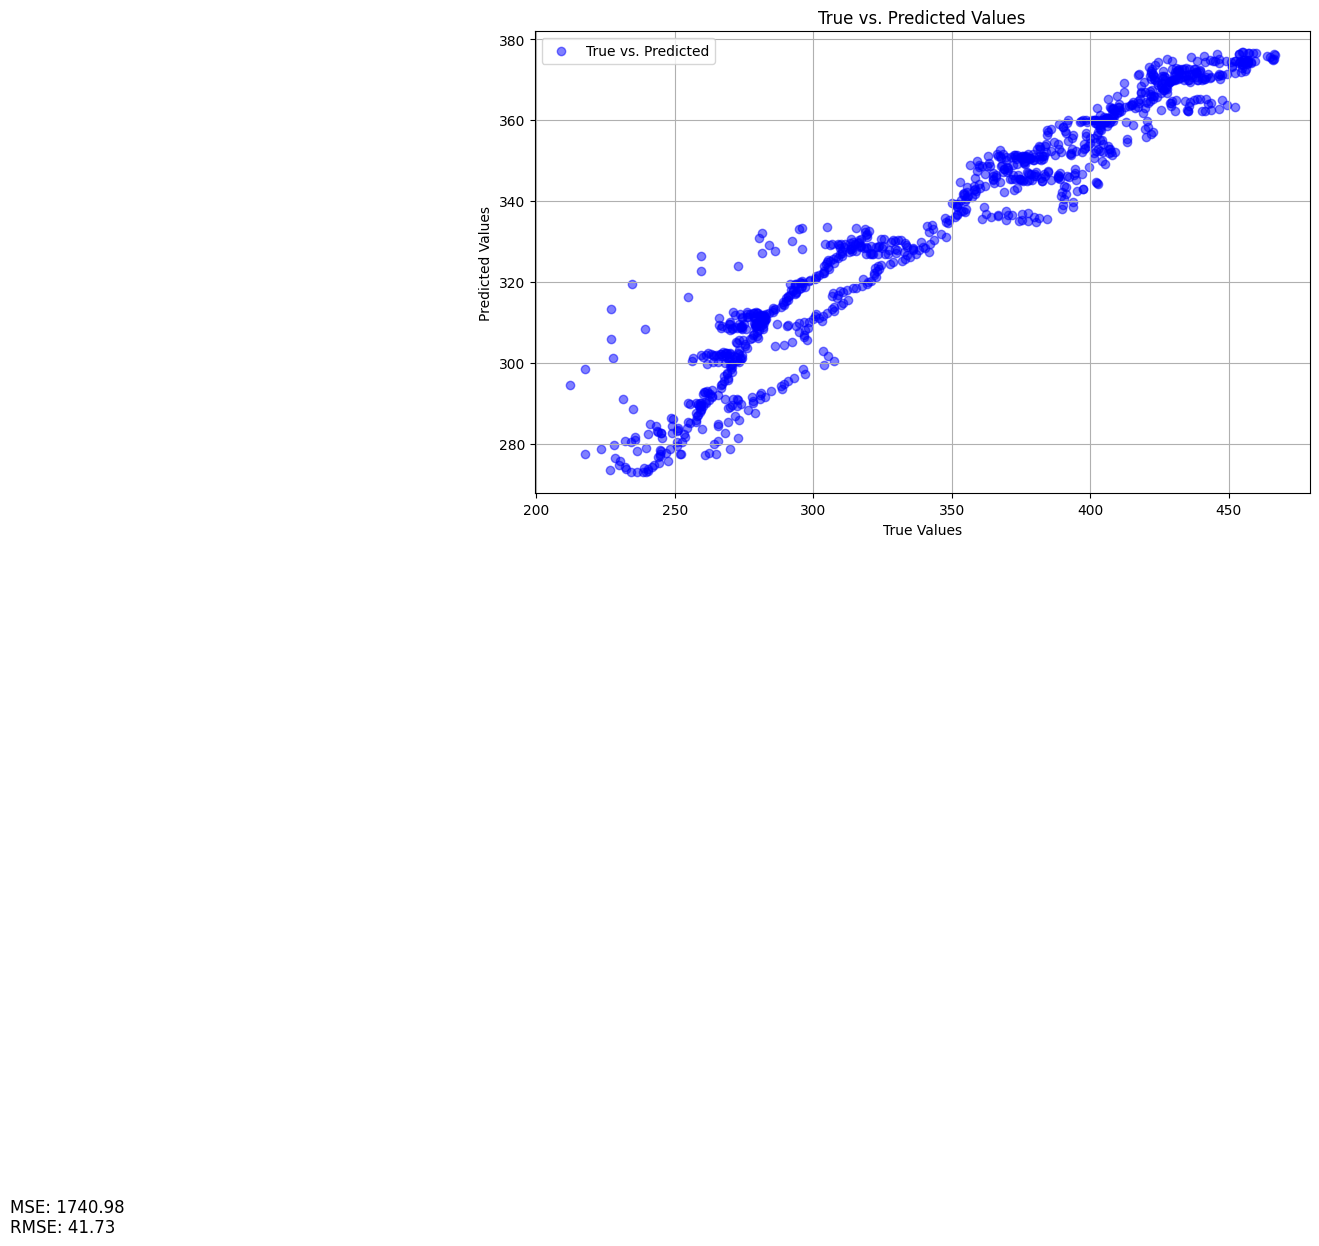

R^2: 0.61
CPU times: user 479 ms, sys: 186 ms, total: 665 ms
Wall time: 482 ms


In [ ]:
%%time
LSTM_show(original,weight_prediction)

new_variable

In [ ]:
%%time
lgb_predictions,model,lgb_original=new_variable(df_30,pred,train_pred)

[I 2023-09-08 03:44:51,061] A new study created in memory with name: no-name-622ccd11-feb1-49e4-a2e3-efa8e5bb10d0
[I 2023-09-08 03:45:12,874] Trial 0 finished with value: 16717.652841289684 and parameters: {'reg_alpha': 1.647198949852325, 'reg_lambda': 2.8442606298801842, 'num_leaves': 50, 'min_child_samples': 76, 'max_depth': 54, 'learning_rate': 0.1, 'colsample_bytree': 0.22226460480571908, 'n_estimators': 3631, 'cat_smooth': 40, 'cat_l2': 1, 'min_data_per_group': 55}. Best is trial 0 with value: 16717.652841289684.


CPU times: user 49.1 s, sys: 289 ms, total: 49.4 s
Wall time: 28.2 s


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
16485.30750025618


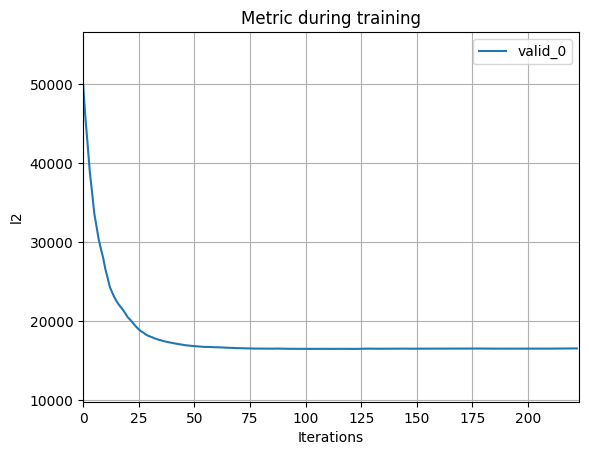

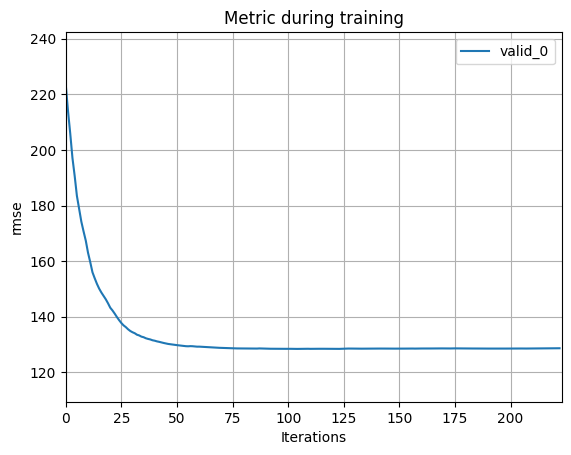

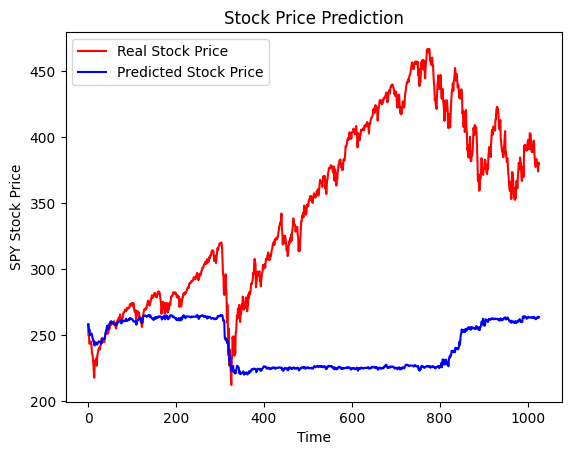

MSE: 16485.31
RMSE: 128.40
R^2: -2.67


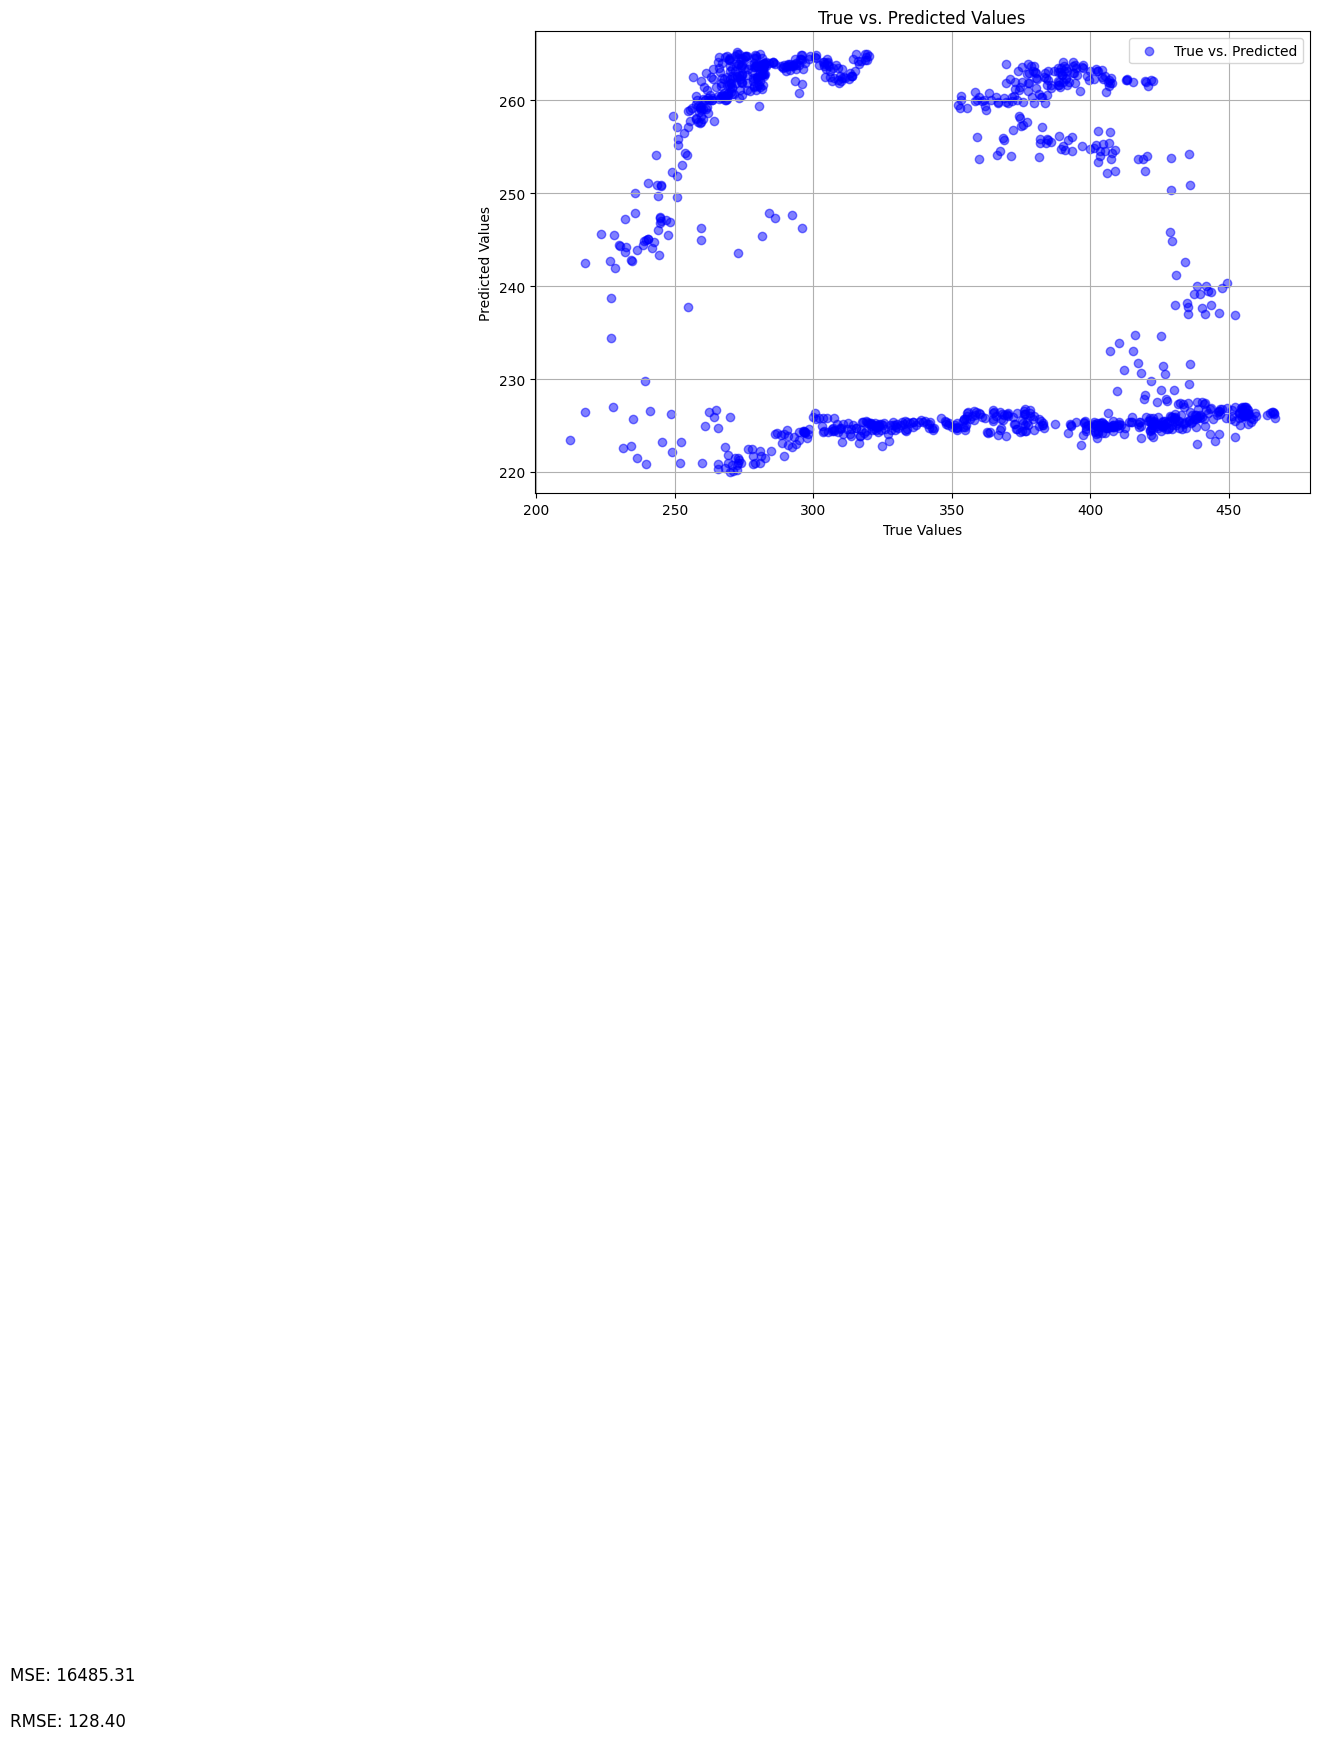

R^2: -2.67


In [ ]:
%time
LightGBM_show(lgb_predictions,model,lgb_original)

**df_40**

lstm prediction

<ipython-input-70-d9085b19990a>:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=model,verbose=1,validation_data=(testX,testY))


Epoch 1/10
7/7 [==============================] - 6s 240ms/step - loss: 0.1543 - val_loss: 0.5694
Epoch 2/10
7/7 [==============================] - 1s 137ms/step - loss: 0.0247 - val_loss: 0.6097
Epoch 3/10
7/7 [==============================] - 1s 137ms/step - loss: 0.0189 - val_loss: 0.4235
Epoch 4/10
7/7 [==============================] - 1s 133ms/step - loss: 0.0096 - val_loss: 0.3960
Epoch 5/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0072 - val_loss: 0.4628
Epoch 6/10
7/7 [==============================] - 1s 142ms/step - loss: 0.0062 - val_loss: 0.4015
Epoch 7/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0047 - val_loss: 0.3308
Epoch 8/10
7/7 [==============================] - 1s 135ms/step - loss: 0.0047 - val_loss: 0.3420
Epoch 9/10
7/7 [==============================] - 1s 181ms/step - loss: 0.0038 - val_loss: 0.3527
Epoch 10/10
2/2 [==============================] - 0s 74ms/step - loss: 4.5760e-04
Epoch 1/10
7/7 [===================

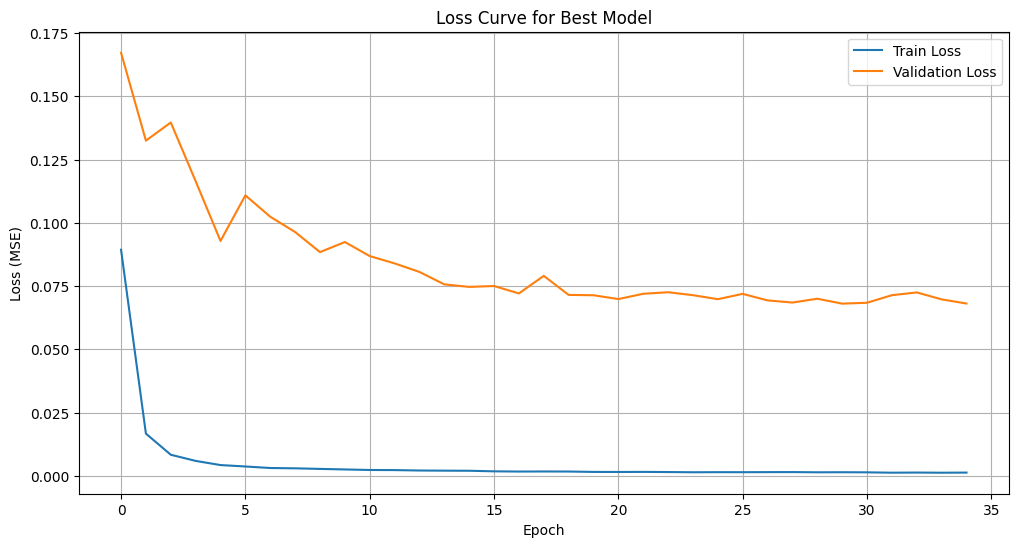

762.9538304805756
CPU times: user 13min 39s, sys: 30.3 s, total: 14min 9s
Wall time: 12min 42s


In [ ]:
%%time
start_time = time.time()
original,pred,train_pred=LSTM_train(df_40,build_model_40,40)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

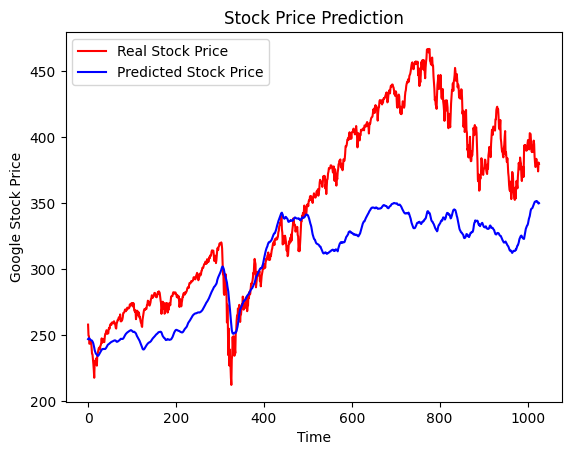

MSE: 3240.58
RMSE: 56.93
R^2: 0.28


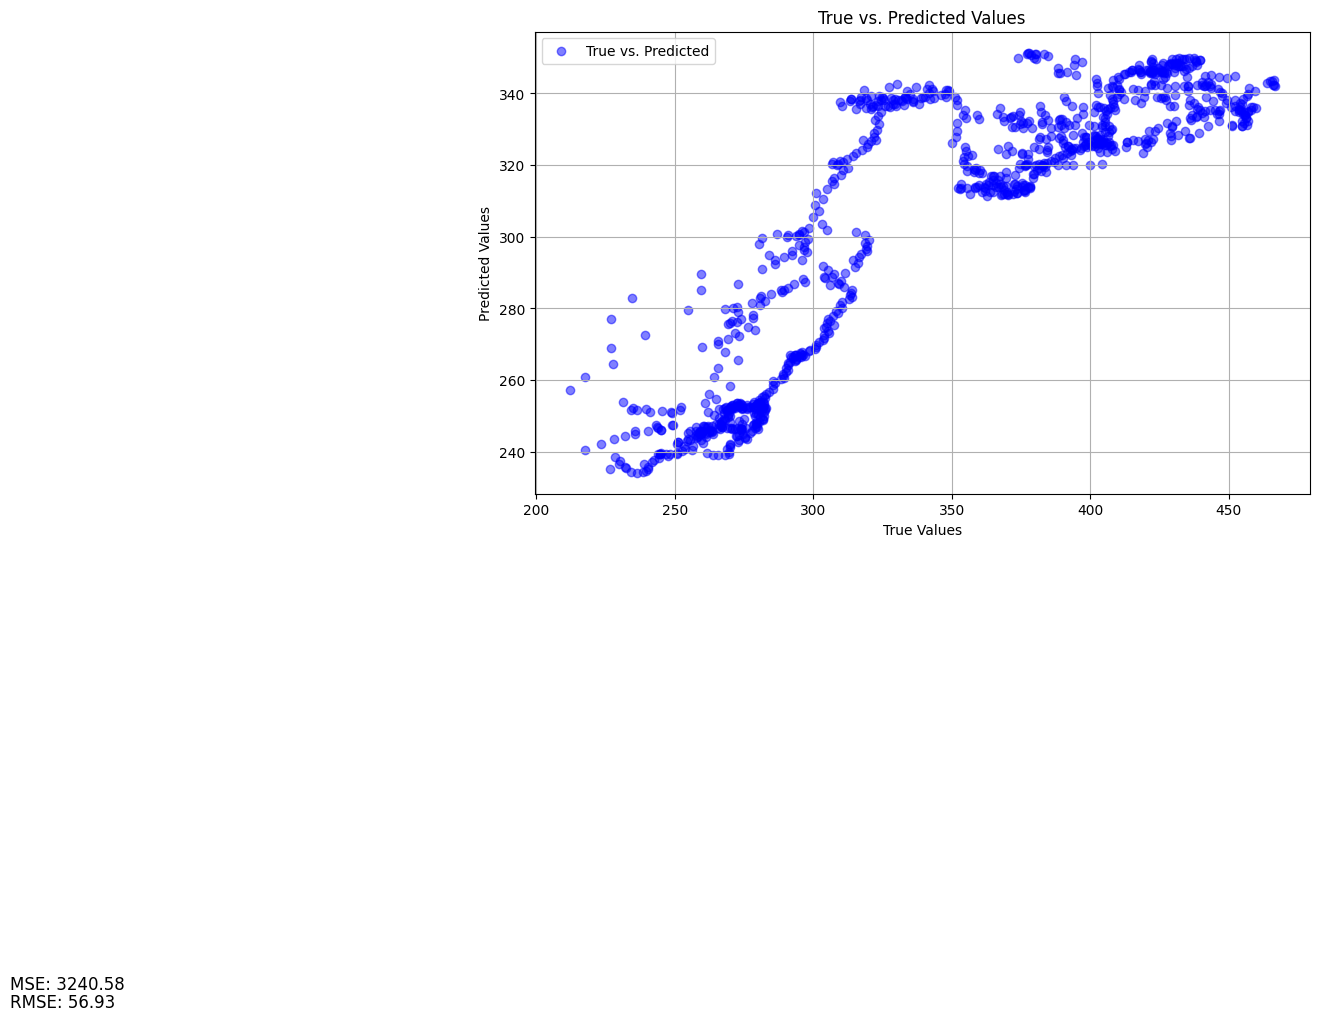

R^2: 0.28
0.4935150146484375
CPU times: user 471 ms, sys: 187 ms, total: 658 ms
Wall time: 494 ms


In [ ]:
%%time
start_time = time.time()
LSTM_show(original,pred)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

lightgbm

In [ ]:
%%time
study=best_param(df_40)
lgb_predictions,model,lgb_original=Light_train(df_40,study)

[I 2023-09-08 03:58:05,074] A new study created in memory with name: no-name-0dc7242f-6c77-42e1-9e4a-ddcc20e53b47
[I 2023-09-08 03:58:26,039] Trial 0 finished with value: 16677.303379808523 and parameters: {'reg_alpha': 8.688057422308008, 'reg_lambda': 2.362587843575411, 'num_leaves': 298, 'min_child_samples': 99, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.13927462173520652, 'n_estimators': 4030, 'cat_smooth': 98, 'cat_l2': 3, 'min_data_per_group': 125}. Best is trial 0 with value: 16677.303379808523.


CPU times: user 47.3 s, sys: 1.3 s, total: 48.6 s
Wall time: 30 s


16490.303038072892


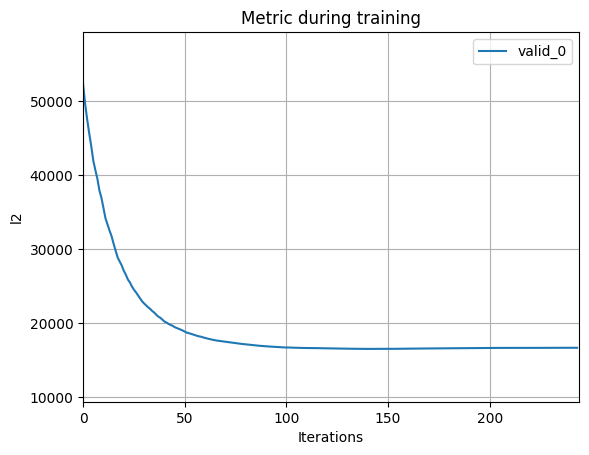

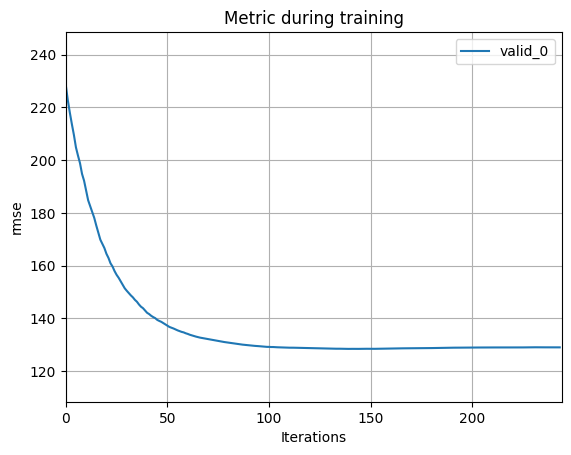

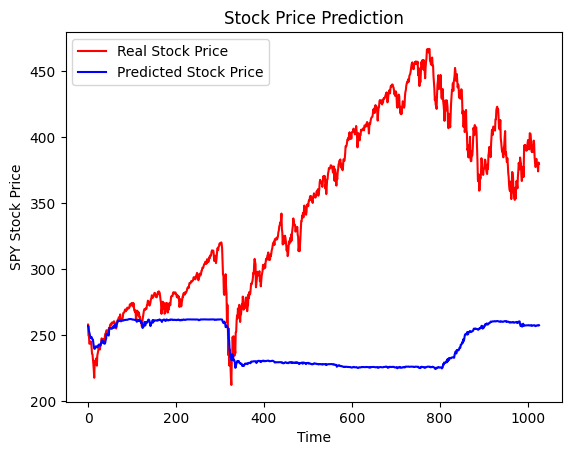

MSE: 16490.30
RMSE: 128.41
R^2: -2.67


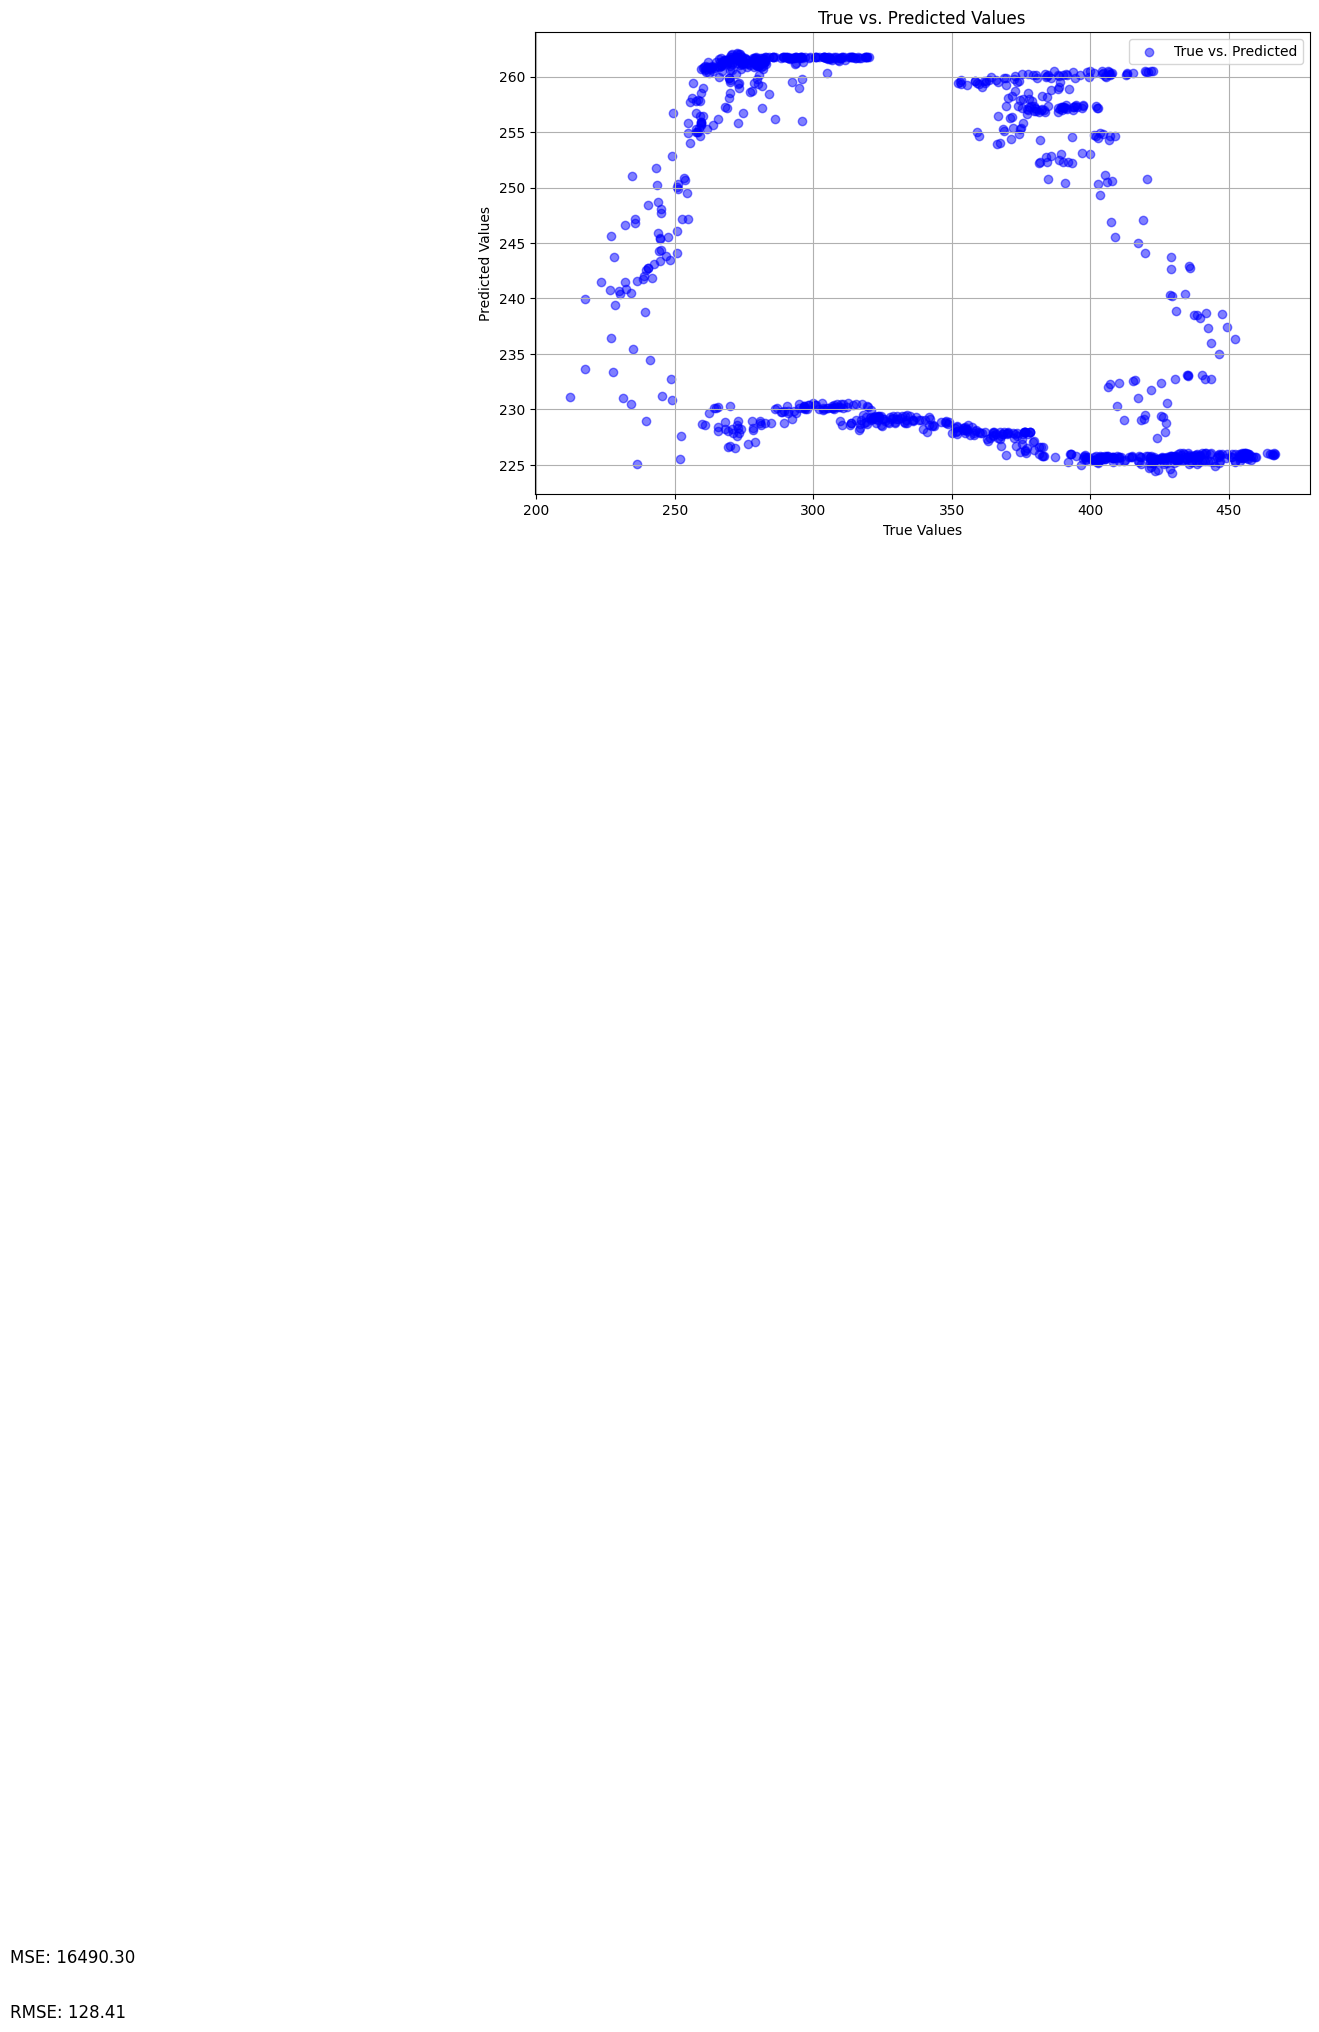

R^2: -2.67
CPU times: user 946 ms, sys: 380 ms, total: 1.33 s
Wall time: 907 ms


In [ ]:
%%time
LightGBM_show(lgb_predictions,model,lgb_original)

weight

In [ ]:
%%time
weight_prediction=weight(pred,original,lgb_predictions)

CPU times: user 2.61 ms, sys: 20 µs, total: 2.63 ms
Wall time: 6.68 ms


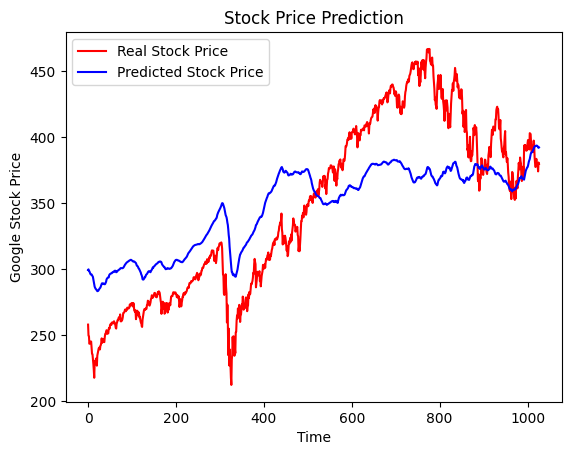

MSE: 1776.58
RMSE: 42.15
R^2: 0.60


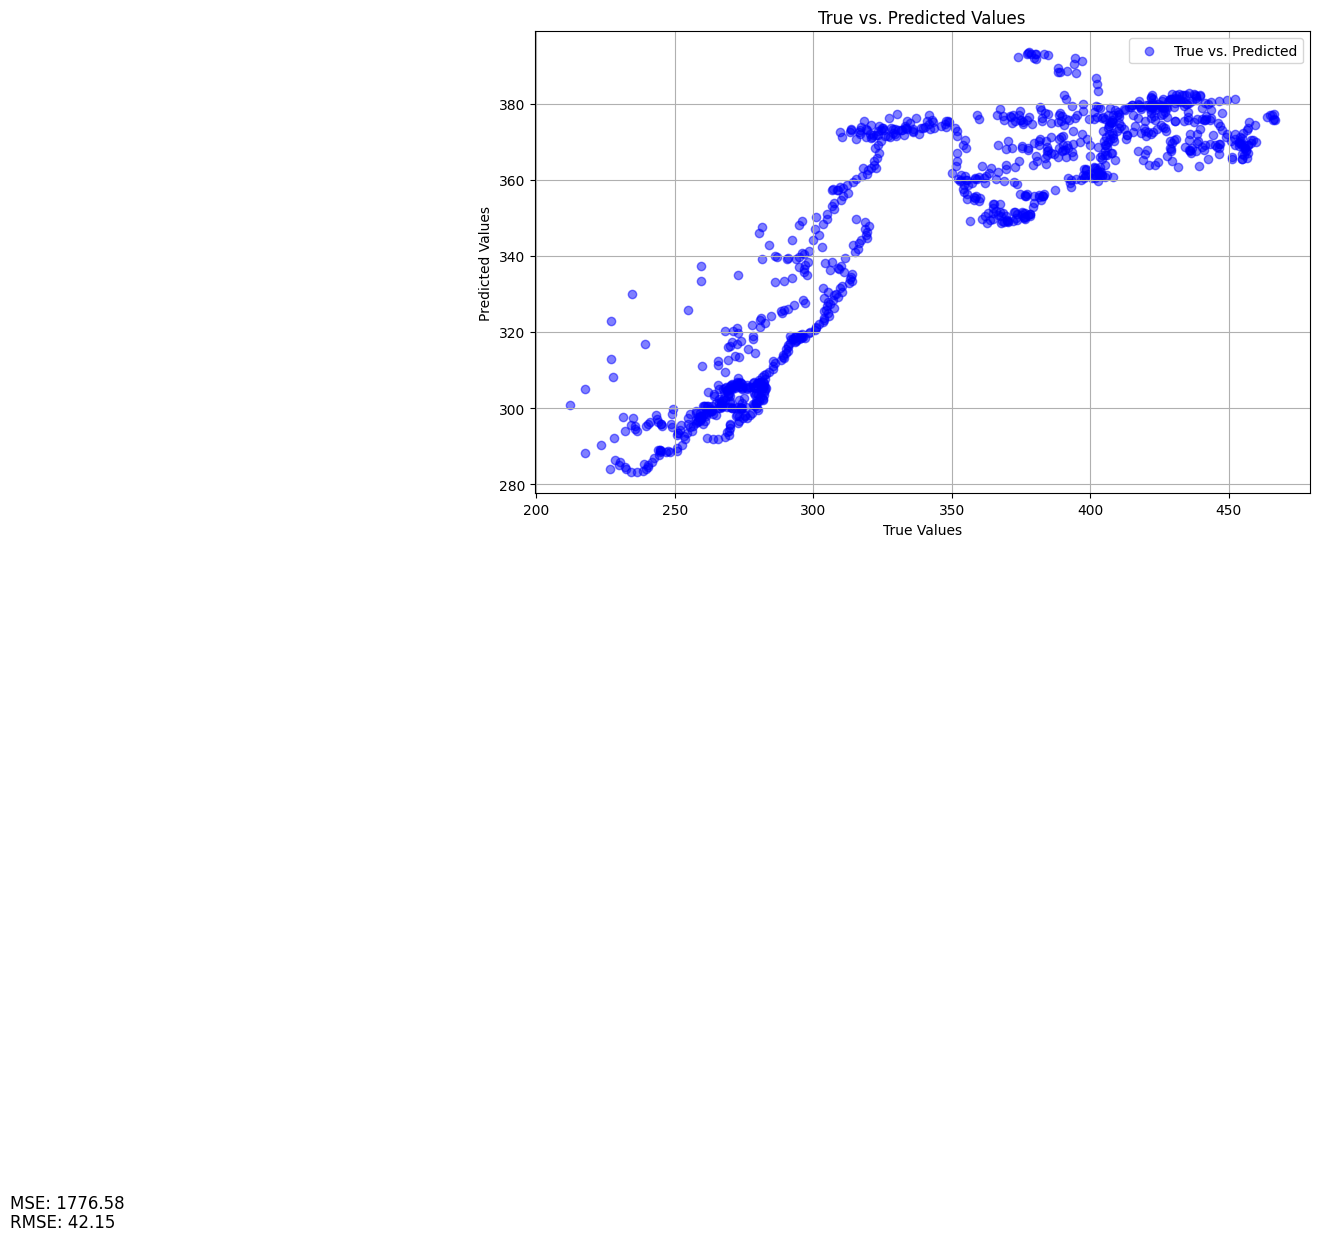

R^2: 0.60
CPU times: user 503 ms, sys: 168 ms, total: 671 ms
Wall time: 480 ms


In [ ]:
%%time
LSTM_show(original,weight_prediction)

new_variable

In [ ]:
%%time
lgb_predictions,model,lgb_original=new_variable(df_40,pred,train_pred)

[I 2023-09-08 03:58:36,542] A new study created in memory with name: no-name-066784f0-54e5-4e40-875f-05f7a0a24a69
[I 2023-09-08 04:01:11,595] Trial 0 finished with value: 15950.11636988382 and parameters: {'reg_alpha': 1.3136525953871303, 'reg_lambda': 5.196730676457672, 'num_leaves': 172, 'min_child_samples': 12, 'max_depth': 55, 'learning_rate': 0.02, 'colsample_bytree': 0.4510224744450875, 'n_estimators': 6725, 'cat_smooth': 67, 'cat_l2': 2, 'min_data_per_group': 151}. Best is trial 0 with value: 15950.11636988382.


CPU times: user 5min 52s, sys: 1.37 s, total: 5min 53s
Wall time: 3min 17s


15818.834432386097


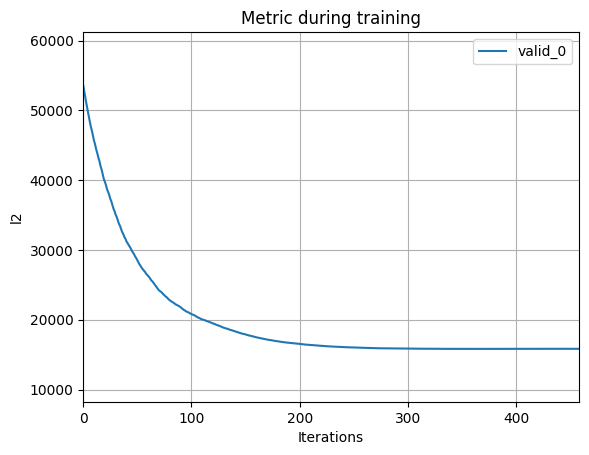

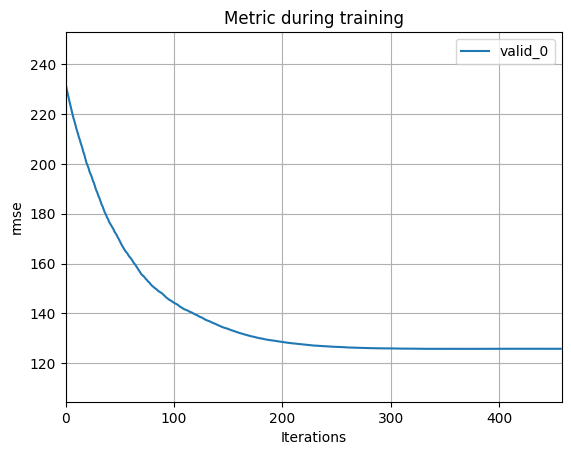

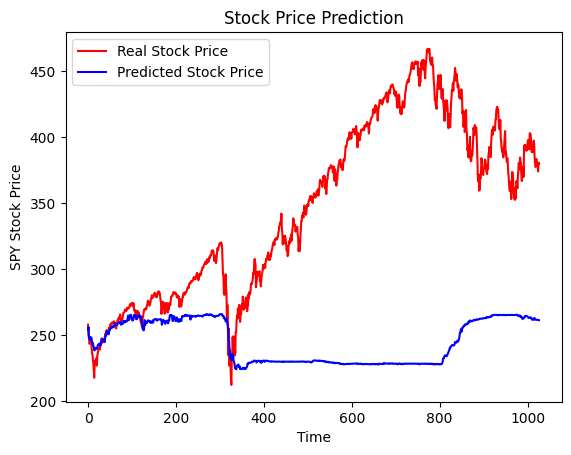

MSE: 15818.83
RMSE: 125.77
R^2: -2.52


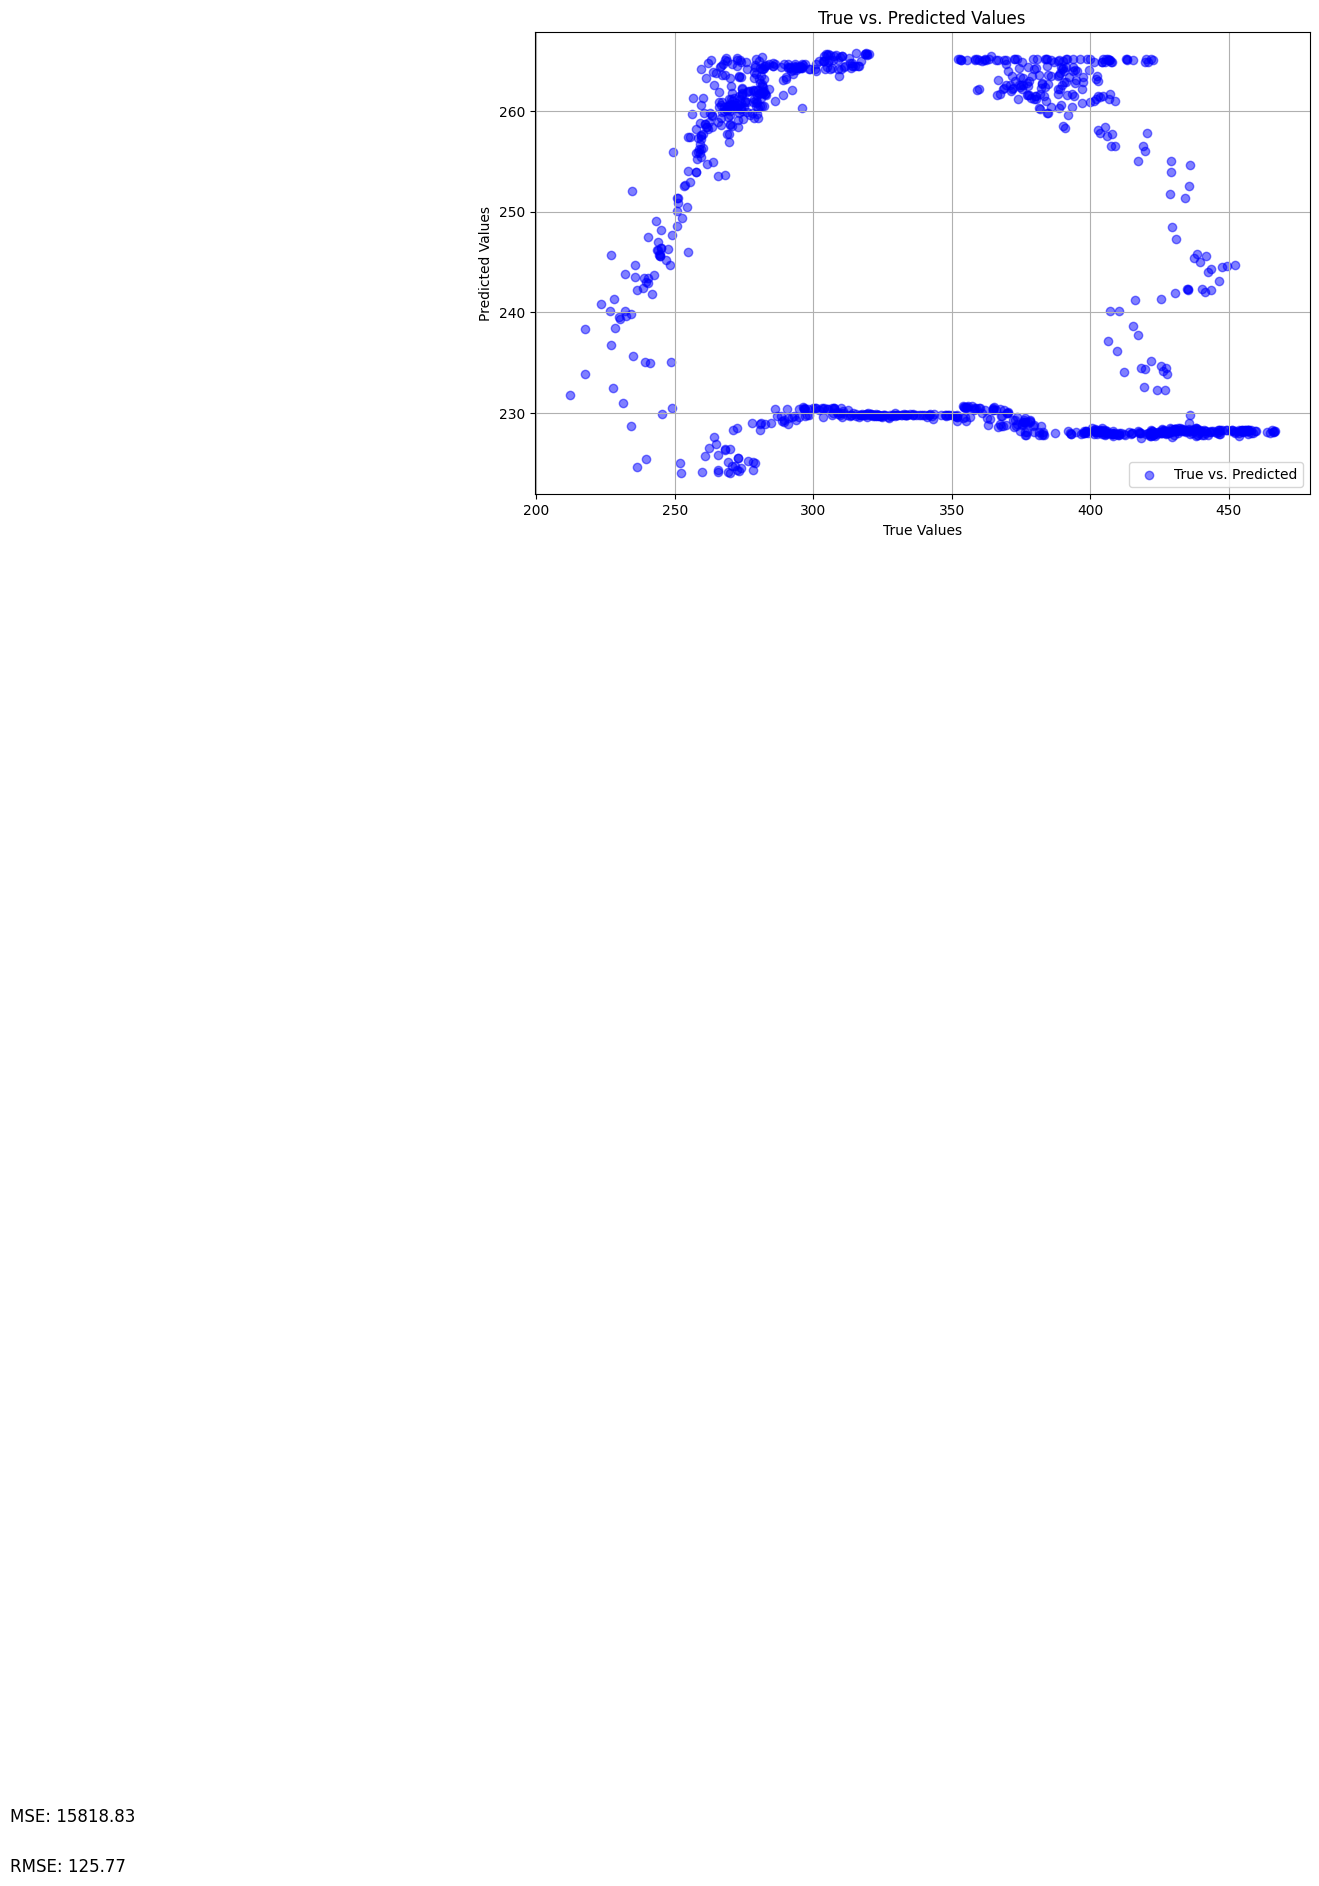

R^2: -2.52
CPU times: user 958 ms, sys: 376 ms, total: 1.33 s
Wall time: 981 ms


In [ ]:
%%time
LightGBM_show(lgb_predictions,model,lgb_original)

**df_50**

lstm prediction

<ipython-input-70-d9085b19990a>:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=model,verbose=1,validation_data=(testX,testY))


Epoch 1/10
7/7 [==============================] - 6s 253ms/step - loss: 0.0521 - val_loss: 0.4446
Epoch 2/10
7/7 [==============================] - 1s 137ms/step - loss: 0.0190 - val_loss: 0.2231
Epoch 3/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0101 - val_loss: 0.3103
Epoch 4/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0070 - val_loss: 0.2138
Epoch 5/10
7/7 [==============================] - 1s 139ms/step - loss: 0.0056 - val_loss: 0.2258
Epoch 6/10
7/7 [==============================] - 1s 142ms/step - loss: 0.0045 - val_loss: 0.2025
Epoch 7/10
7/7 [==============================] - 1s 198ms/step - loss: 0.0038 - val_loss: 0.2246
Epoch 8/10
7/7 [==============================] - 2s 244ms/step - loss: 0.0038 - val_loss: 0.2011
Epoch 9/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0032 - val_loss: 0.2108
Epoch 10/10
2/2 [==============================] - 0s 40ms/step - loss: 2.5081e-04
Epoch 1/10
7/7 [===================

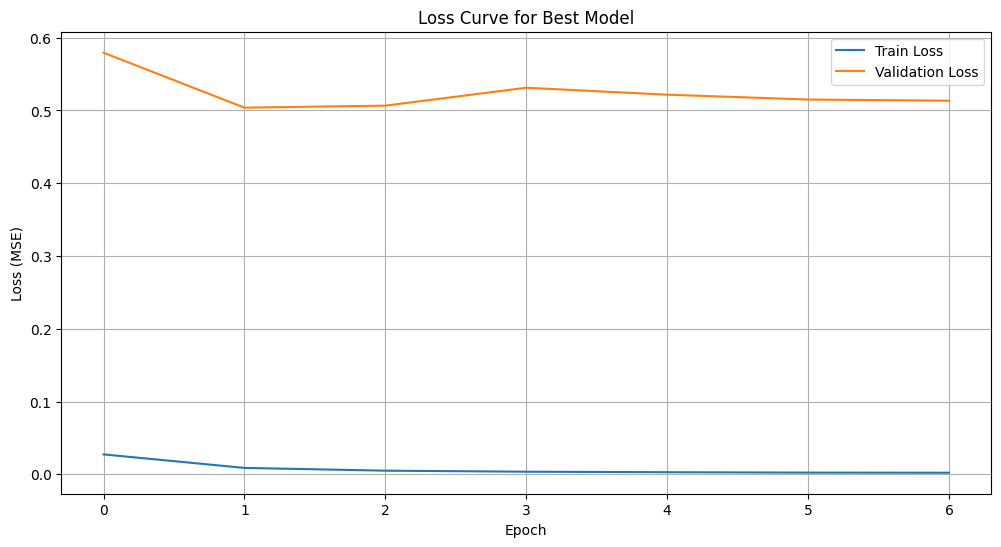

766.9735908508301
CPU times: user 12min 25s, sys: 27.1 s, total: 12min 52s
Wall time: 12min 46s


In [ ]:
%%time
start_time = time.time()
original,pred,train_pred=LSTM_train(df_50,build_model_50,50)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

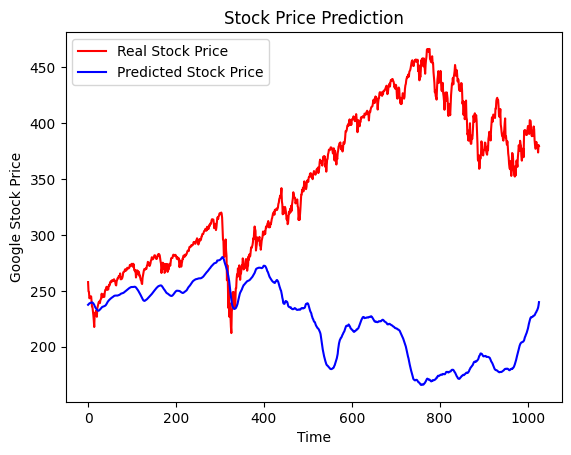

MSE: 23994.43
RMSE: 154.90
R^2: -4.34


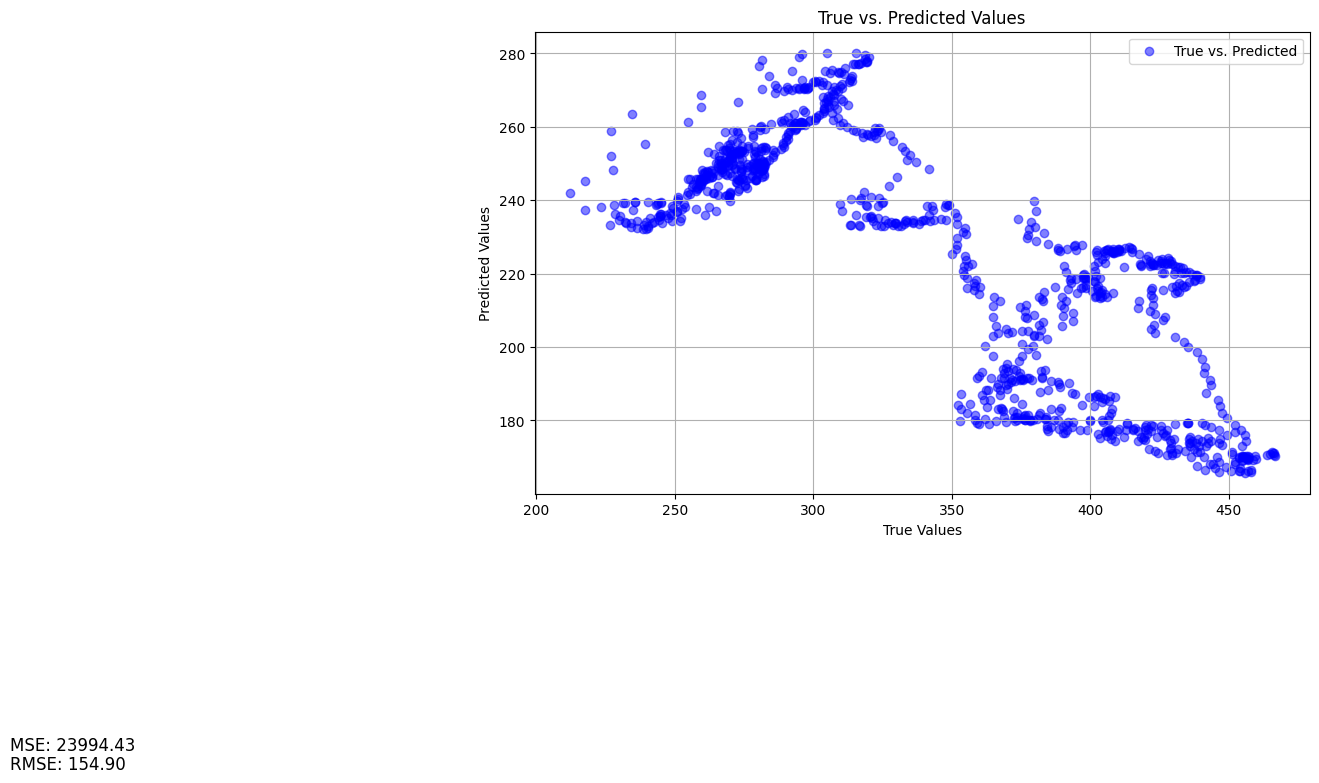

R^2: -4.34
0.44623541831970215
CPU times: user 478 ms, sys: 180 ms, total: 658 ms
Wall time: 446 ms


In [ ]:
%%time
start_time = time.time()
LSTM_show(original,pred)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

lightgbm

In [ ]:
%%time
study=best_param(df_50)
lgb_predictions,model,lgb_original=Light_train(df_50,study)

[I 2023-09-08 04:14:42,462] A new study created in memory with name: no-name-a344422f-7d0a-45a6-a3f6-35672cbcdc59
[I 2023-09-08 04:19:02,488] Trial 0 finished with value: 16320.541282711716 and parameters: {'reg_alpha': 0.8201571007151389, 'reg_lambda': 8.880433288289478, 'num_leaves': 100, 'min_child_samples': 9, 'max_depth': 30, 'learning_rate': 0.01, 'colsample_bytree': 0.1962169515443395, 'n_estimators': 6026, 'cat_smooth': 54, 'cat_l2': 15, 'min_data_per_group': 111}. Best is trial 0 with value: 16320.541282711716.


CPU times: user 10min 7s, sys: 2.26 s, total: 10min 9s
Wall time: 5min 39s


16296.983069579708


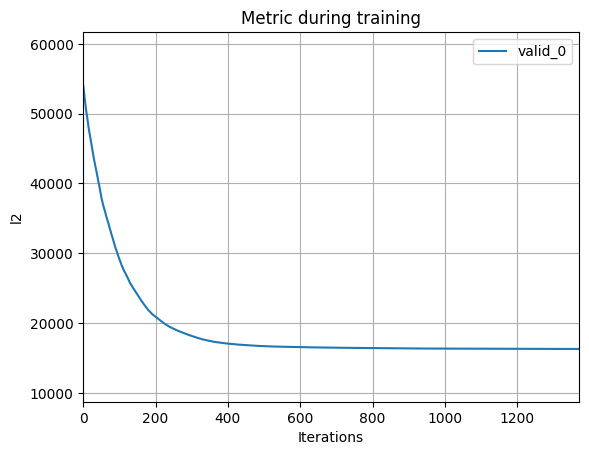

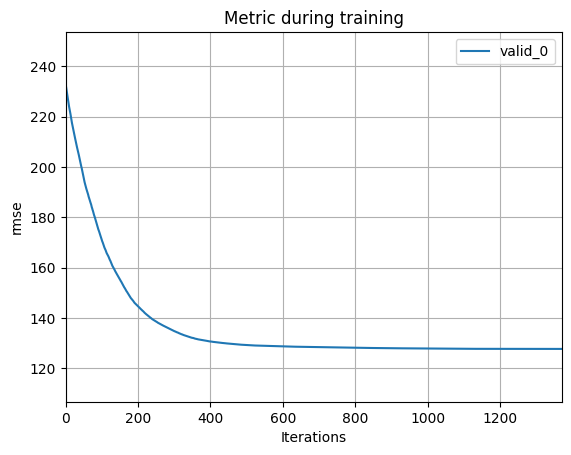

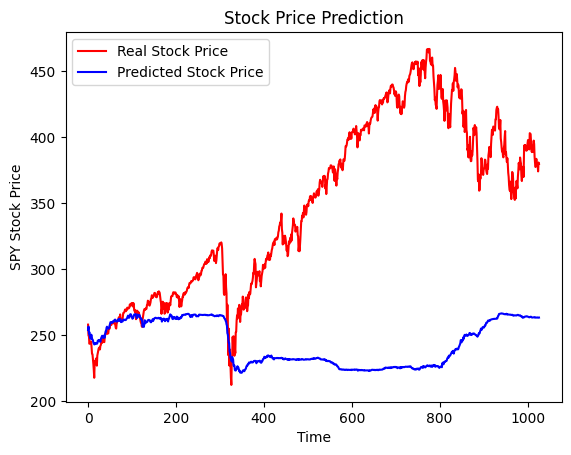

MSE: 16296.98
RMSE: 127.66
R^2: -2.63


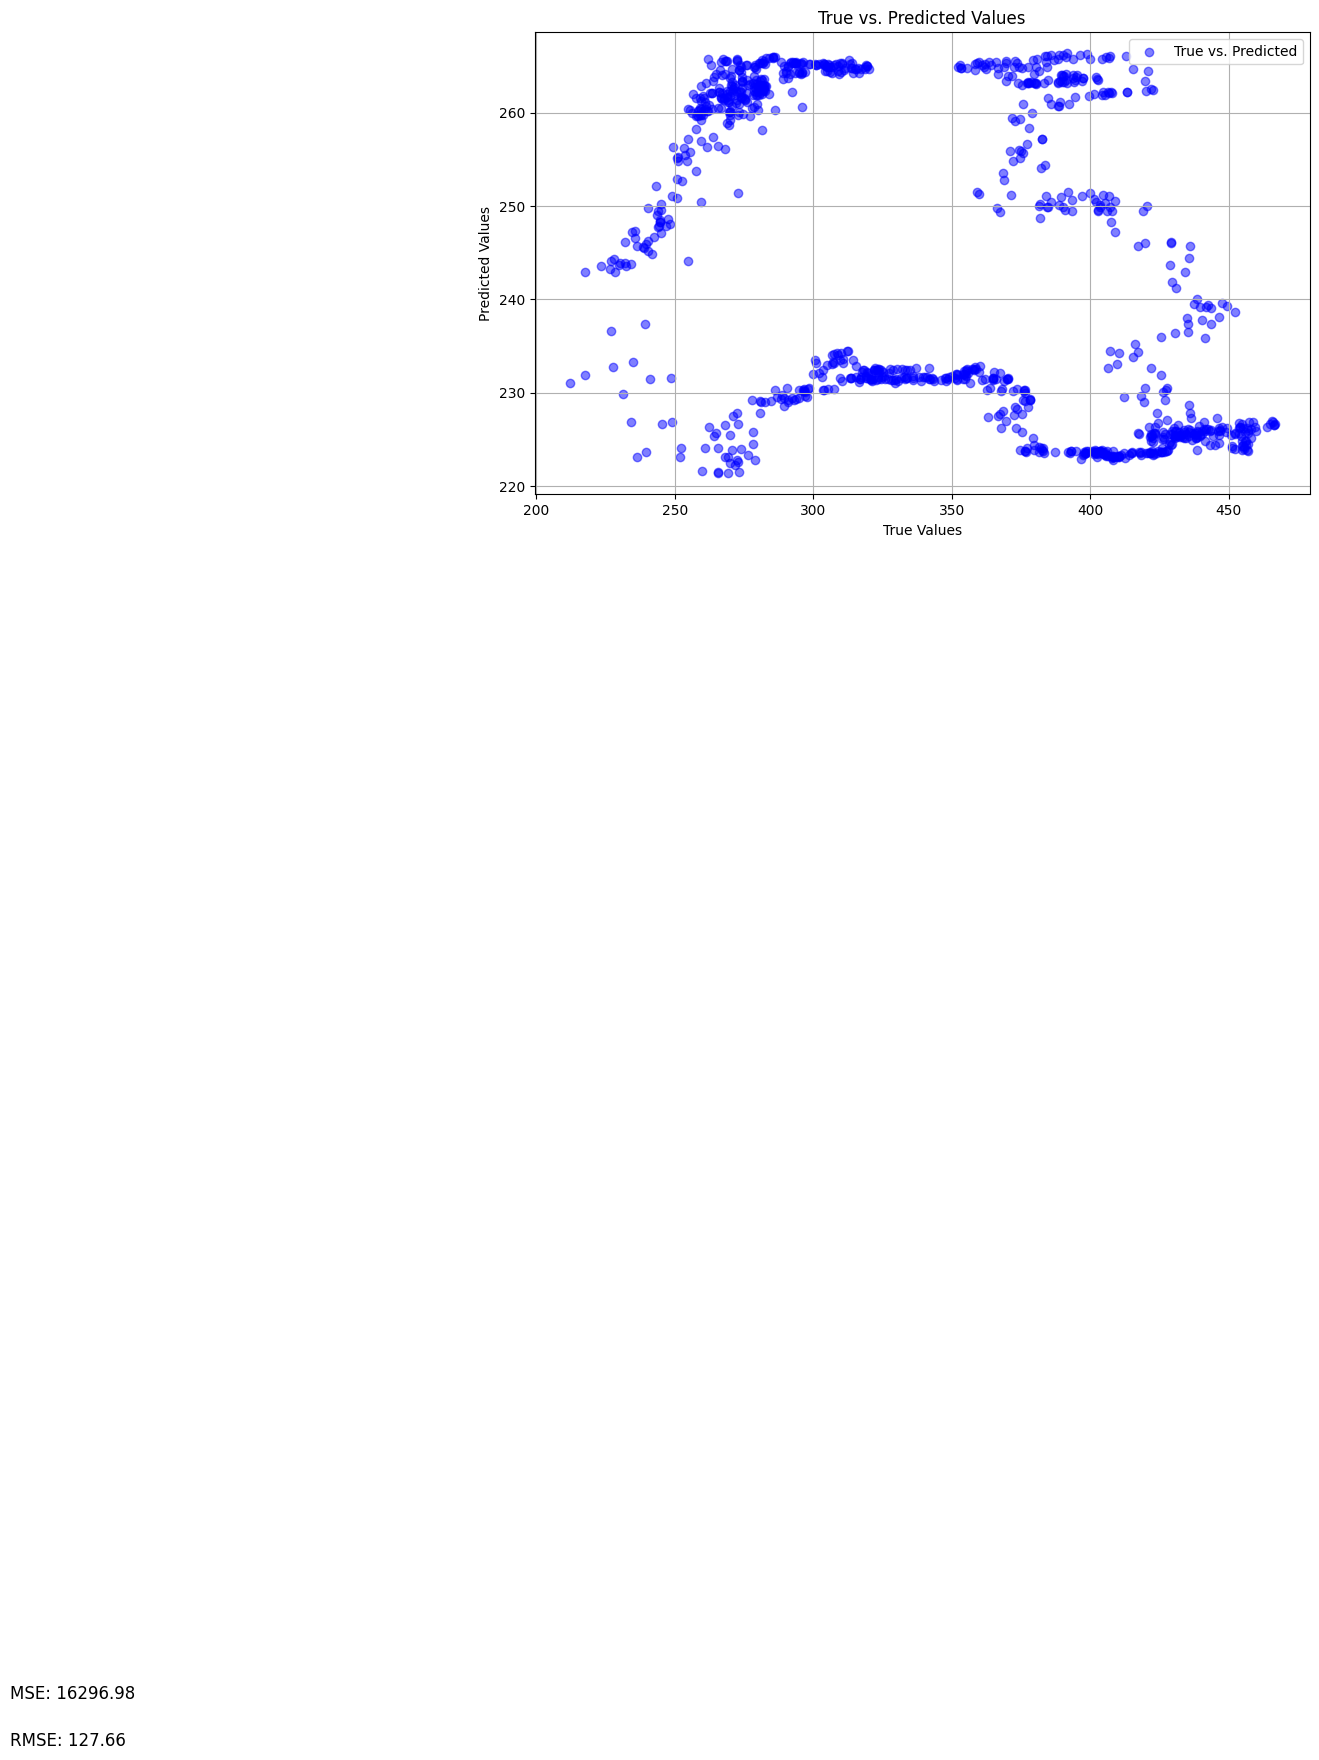

R^2: -2.63
CPU times: user 892 ms, sys: 387 ms, total: 1.28 s
Wall time: 859 ms


In [ ]:
%%time
LightGBM_show(lgb_predictions,model,lgb_original)

weight

In [ ]:
%%time
weight_prediction=weight(pred,original,lgb_predictions)

CPU times: user 3.2 ms, sys: 6 µs, total: 3.2 ms
Wall time: 5.52 ms


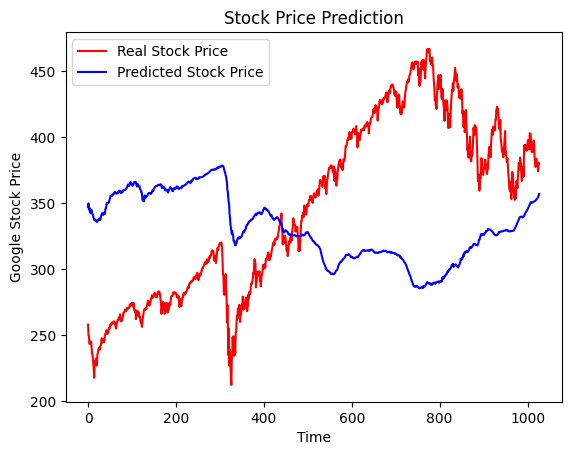

MSE: 7954.28
RMSE: 89.19
R^2: -0.77


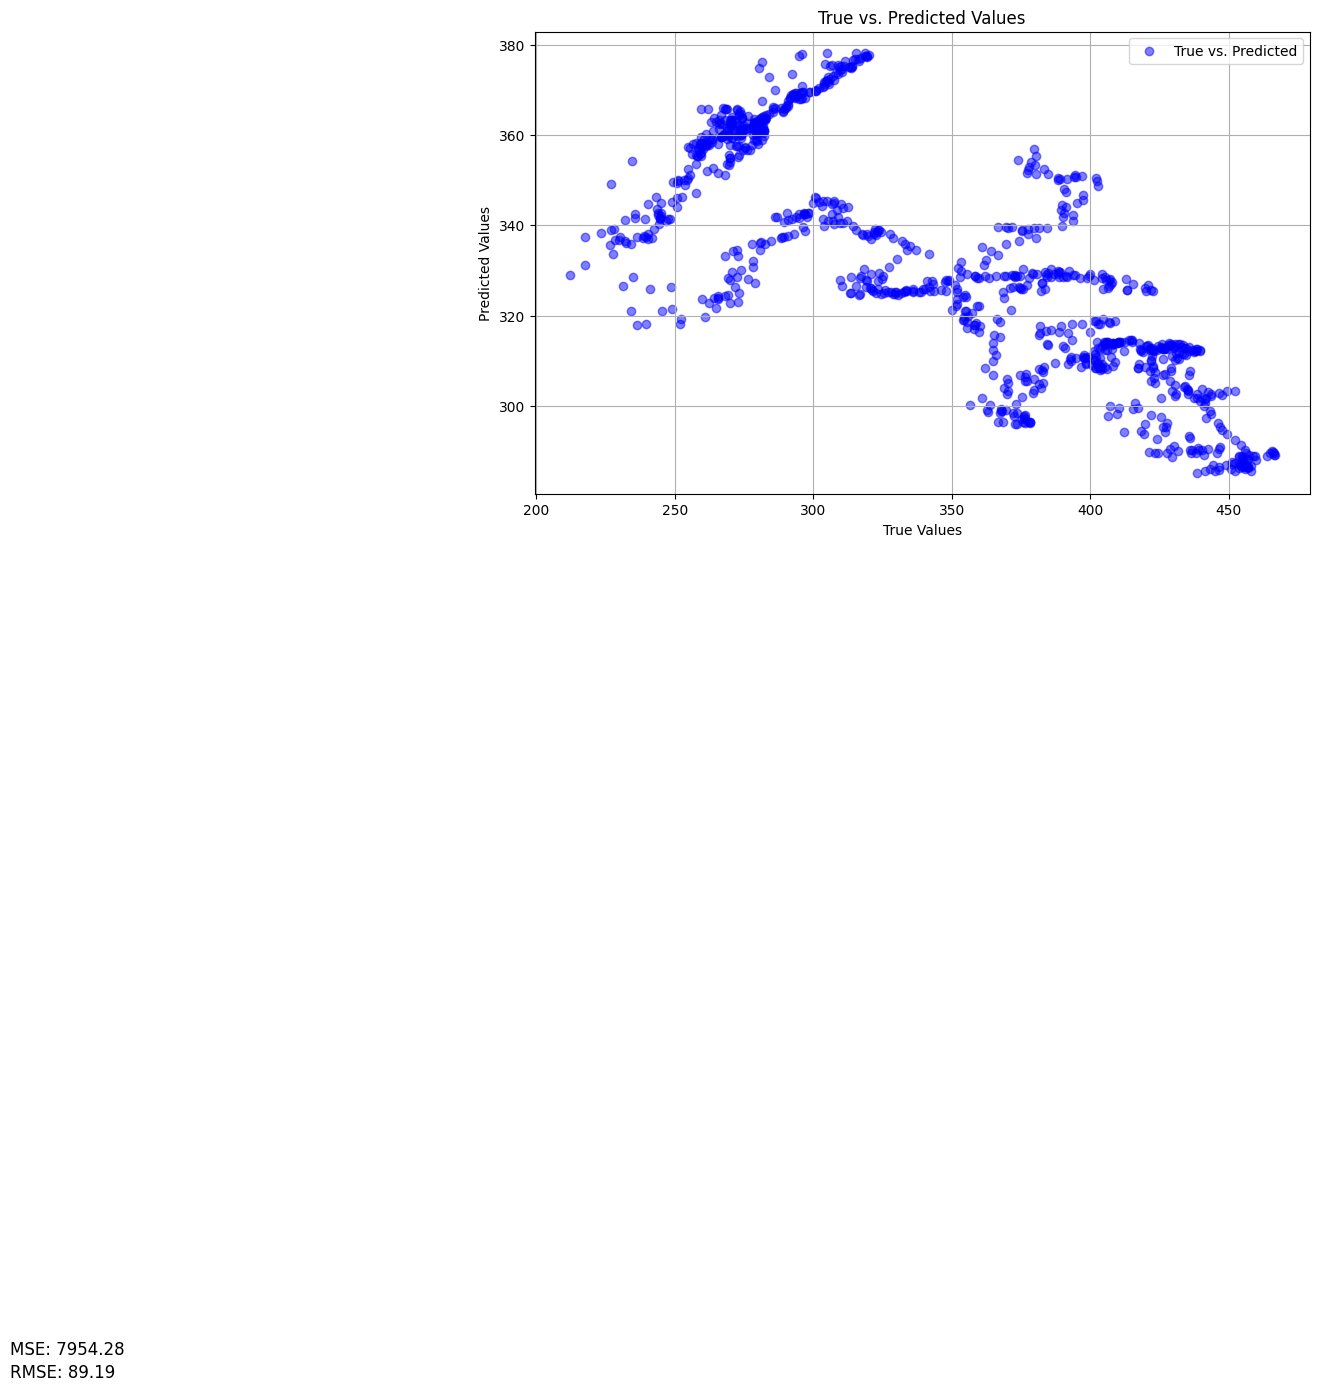

R^2: -0.77
CPU times: user 515 ms, sys: 193 ms, total: 709 ms
Wall time: 485 ms


In [ ]:
%%time
LSTM_show(original,weight_prediction)

new_variable

In [ ]:
%%time
lgb_predictions,model,lgb_original=new_variable(df_50,pred,train_pred)

[I 2023-09-08 04:20:23,575] A new study created in memory with name: no-name-ac1f50b5-180f-422c-98d9-81eab9ffaa7a
[I 2023-09-08 04:22:16,192] Trial 0 finished with value: 16409.096486876384 and parameters: {'reg_alpha': 6.627784571652494, 'reg_lambda': 7.130438762351361, 'num_leaves': 150, 'min_child_samples': 97, 'max_depth': 14, 'learning_rate': 0.005, 'colsample_bytree': 0.4860684770215855, 'n_estimators': 2589, 'cat_smooth': 33, 'cat_l2': 17, 'min_data_per_group': 150}. Best is trial 0 with value: 16409.096486876384.


CPU times: user 5min 16s, sys: 1 s, total: 5min 17s
Wall time: 2min 57s


16298.865074668229


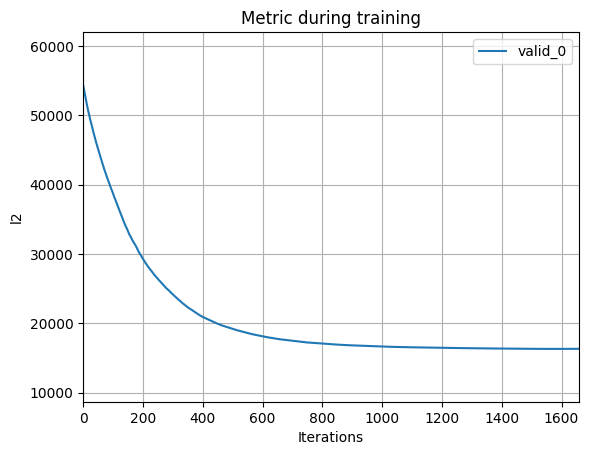

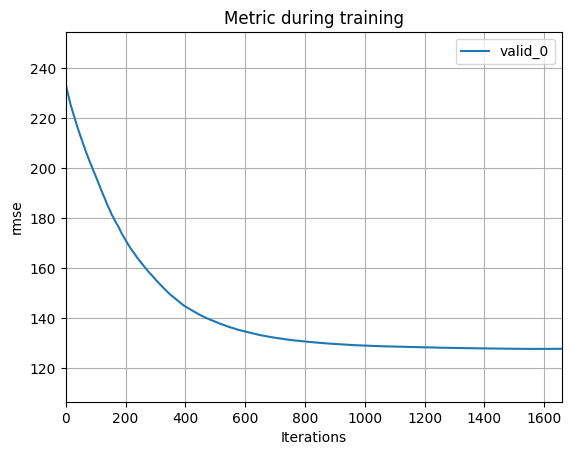

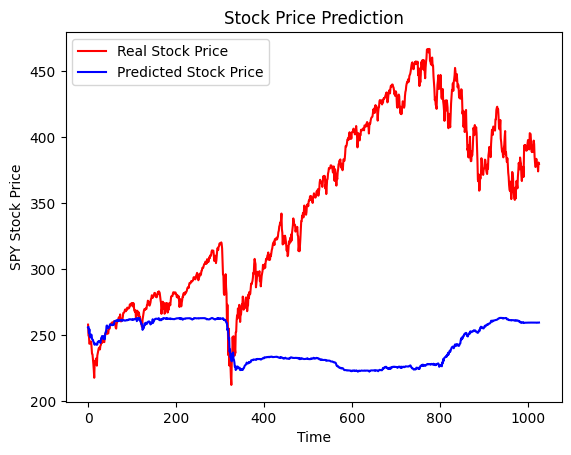

MSE: 16298.87
RMSE: 127.67
R^2: -2.63


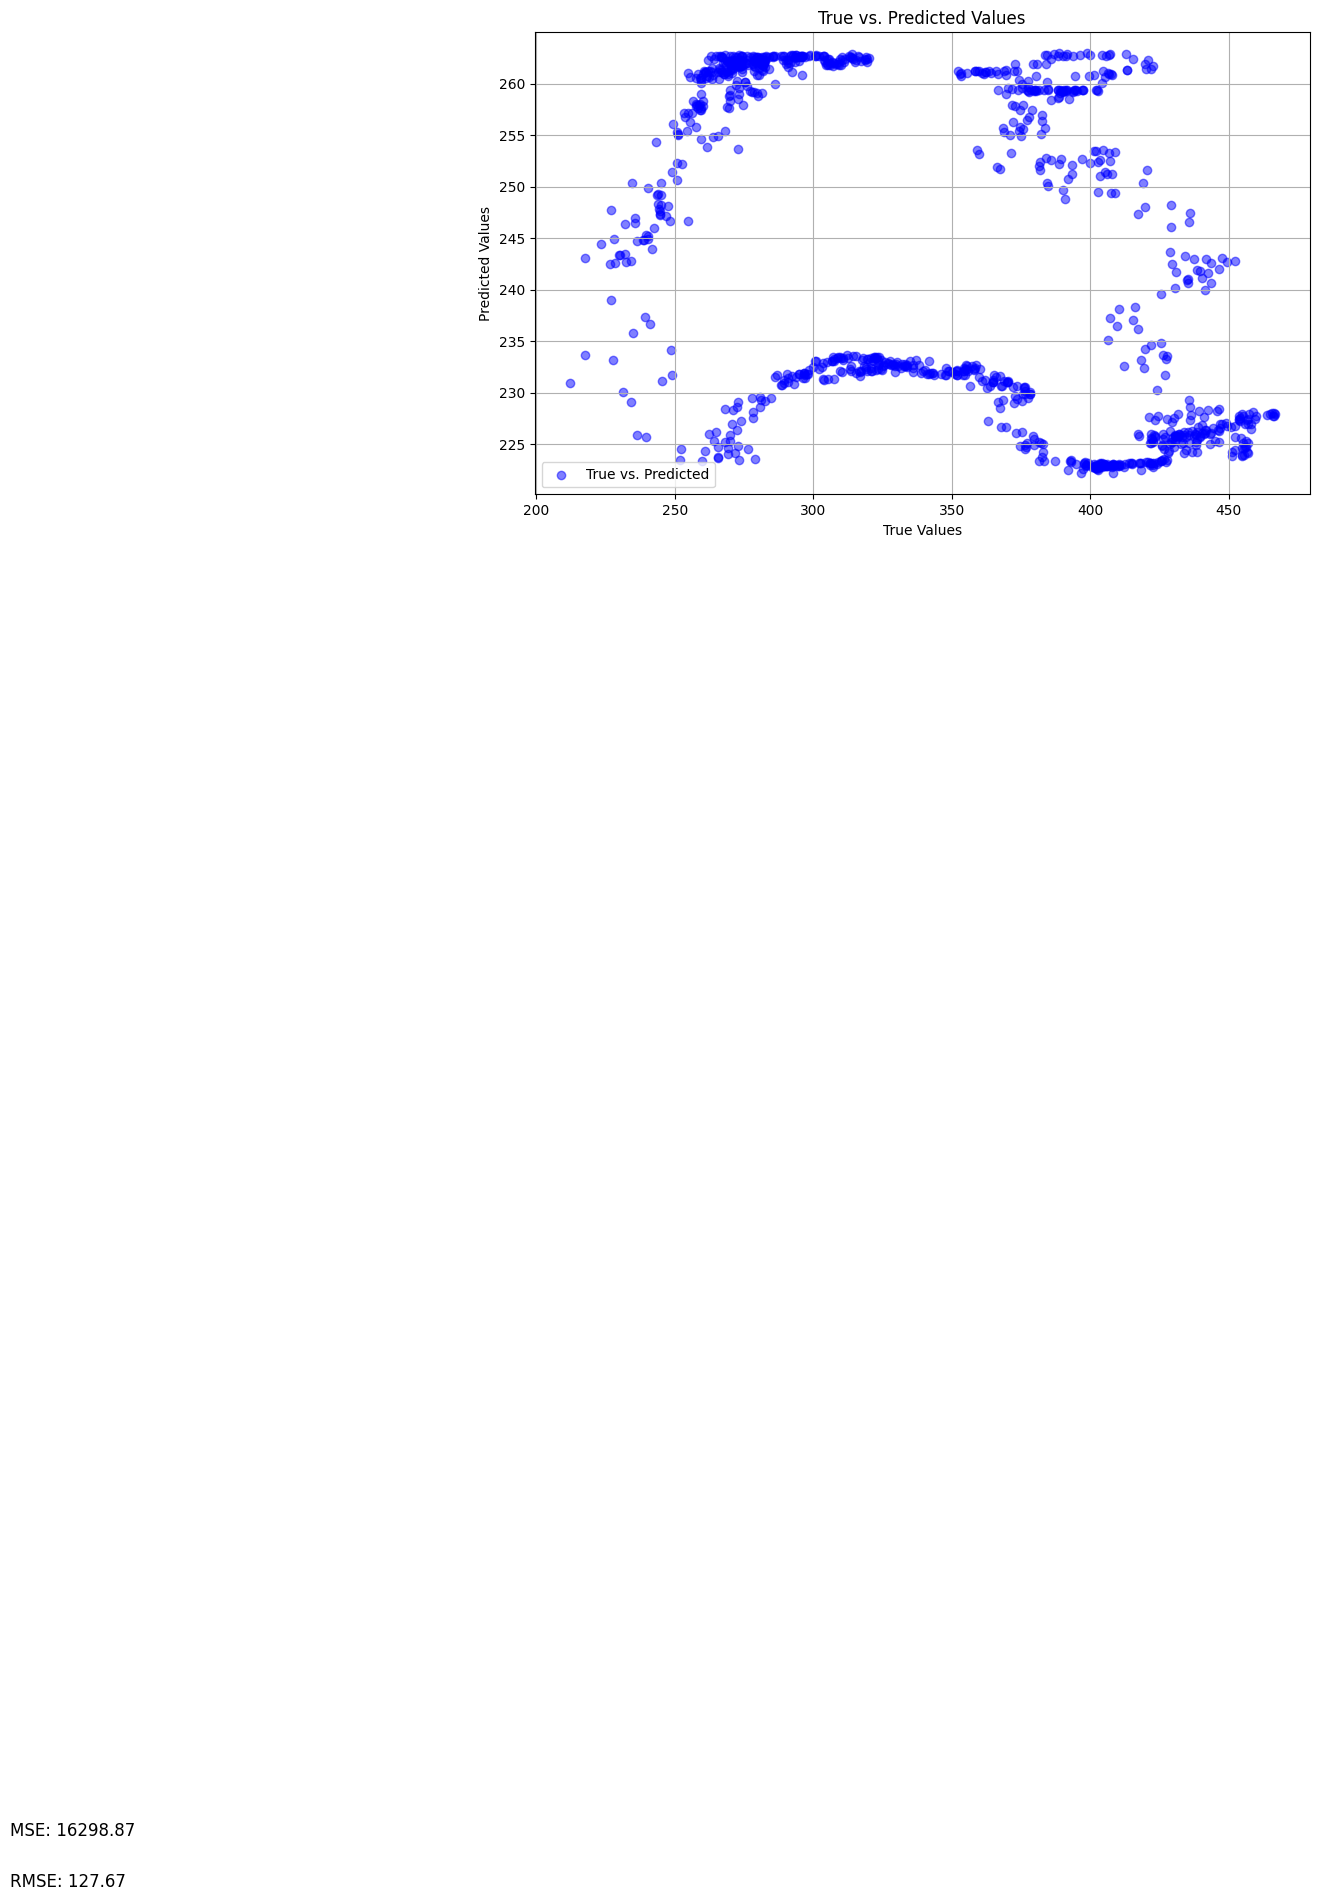

R^2: -2.63
CPU times: user 977 ms, sys: 346 ms, total: 1.32 s
Wall time: 946 ms


In [ ]:
%%time
LightGBM_show(lgb_predictions,model,lgb_original)

In [ ]:
!jupyter nbconvert --to html *.ipynb

[NbConvertApp] Converting notebook code1.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][44]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stderr',
 'output_type': 'stream',
 'text': '<ipython-input-70-d9085b19990a>:7: DeprecationWarning: '
         'KerasRegr...'}
[NbConvertApp] Writing 5727281 bytes to code1.html


just for test

In [ ]:
window_size = 30  # Define the size of the rolling window

# Function to create rolling windows from the data
def create_rolling_windows(X, y, window_size):
    X_rolling, y_rolling = [], []
    num_samples = len(X)
    for i in range(30, num_samples):
        X_rolling.append(X.iloc[i-30:i].values.reshape(-1))  # Flatten the window
        y_rolling.append(y.iloc[i])
    return np.array(X_rolling), np.array(y_rolling)

# Split your data into training and testing sets
test_split=round(len(df_10)*0.20)
train_data=df_10[:-test_split]
test_data=df_10[-test_split:]
train_data=train_data.reset_index(drop=True)
test_data=test_data.reset_index(drop=True)
train_x=train_data.iloc[:,1:]
train_y=train_data.iloc[:,0]
test_x=test_data.iloc[:,1:]
test_y=test_data.iloc[:,0]
# Create rolling windows for training and testing
X_train_rolling, y_train_rolling = create_rolling_windows(train_x, train_y, window_size)
X_test_rolling, y_test_rolling = create_rolling_windows(test_x, test_y, window_size)

In [ ]:
test_split=round(len(df)*0.20)
train_data=df[:-test_split]
test_data=df[-test_split:]

lgb_train = lgb.Dataset(X_train_rolling, y_train_rolling)
lgb_eval = lgb.Dataset(X_test_rolling, y_test_rolling, reference=lgb_train)
evals_result = {}
params = {
'boosting_type': 'gbdt',                       # 设置提升类型
'objective': 'regression',                 # 目标函数
'metric': ['l2','rmse','mae'],              # 评估函数
'verbose': 1,                          #  <0 显示致命的, =0 显示错误 (警告), >0 显示信息
'early_stopping_round': 1000
}
model = LGBMRegressor(**params)
model.fit(X_train_rolling,y_train_rolling,eval_set=[(X_test_rolling,y_test_rolling)],eval_metric=['l2','rmse','mae'])
preds = model.predict(X_test_rolling)
lgb_predictions = model.predict(X_test_rolling, num_iteration=model.best_iteration_)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 4200, number of used features: 300
[LightGBM] [Info] Start training from score 122.443888
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's l2: 11040.4	valid_0's rmse: 105.073	valid_0's l1: 83.6288


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

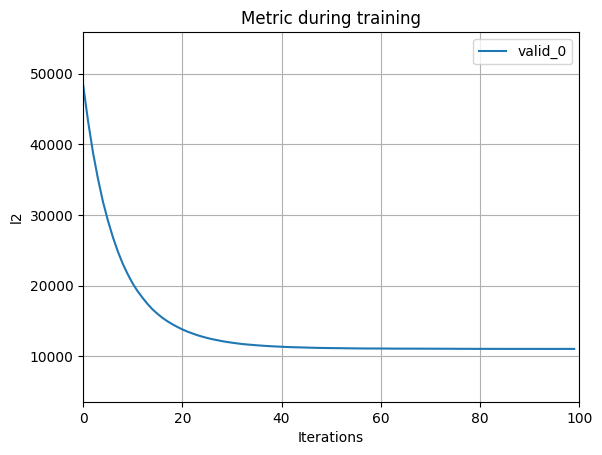

In [ ]:
lgb.plot_metric(model,'l2')

In [ ]:
lgb_predictions

array([254.50869064, 257.91749528, 252.22292736, ..., 264.870193  ,
       263.61852793, 267.36541133])

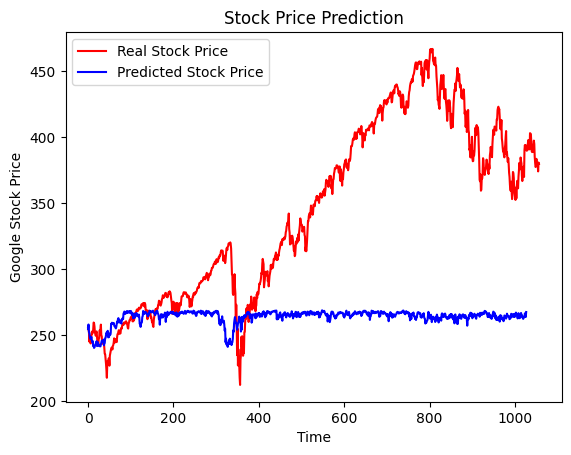

In [ ]:

plt.plot(test_y, color = 'red', label = 'Real Stock Price')
plt.plot(lgb_predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))



reg_alpha: 7.063638468830788
reg_lambda: 0.006831767159972453
num_leaves: 260
min_child_samples: 7
max_depth: 10
learning_rate: 0.01
colsample_bytree: 0.23317637413065107
n_estimators: 4332
cat_smooth: 37
cat_l2: 7
min_data_per_group: 53
